# 1.) Data preprocessing

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import requests
import json
import seaborn as sns
import re
from datetime import datetime
from datetime import date
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
#Ceilometer data
def parse_CL(site):
    df = pd.concat([pd.read_csv(file) for file in glob(f'Ceilometer/*{site}.csv')])

    # replace -999 to NaN
    df = df.replace(-999, np.nan)

    # parse date string
    df['# Time'] = pd.to_datetime(df['# Time'], format='%d/%m/%Y %H:%M:%S')
    
    # interpolate bl_height by time
    df['revised_bl_height'] = df.set_index('# Time')['bl_height'].interpolate(method='time').values

    # aggregate bl_height by hourly average
    df = df.groupby([
        df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['# Time'].dt.hour.rename('Hour')
    ])['revised_bl_height'].mean().reset_index(name='CL_BLH').set_index(['Date', 'Hour'])

    return df

#CTM model data
def parse_CTM(site, time_offset=10):
    # Careful! The seperator is not ',' but ', ' (space)
    df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'CTM_ModelOutput/*{site}.csv')])

    # parse date string
    from datetime import timedelta
    df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

    df = df.groupby([
        df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['Time'].dt.hour.rename('Hour')
    ])['mixing_height'].mean().reset_index(name='CTM_BLH').set_index(['Date', 'Hour'])

    return df

In [3]:
def convert_df_to_datetime_wrf(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d_%H:%M:%S')+ timedelta(hours=10)
    
    #Set index to datetime
    df = df.set_index('datetime')
    
    #Keep the last index
    #As per Hiep response - 24/8/2021 - we keep last value

    df = df[~df.index.duplicated(keep = 'last')]

    df = df.reset_index()
    #Set index to datetime
    df = df.groupby([
        df['datetime'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['datetime'].dt.hour.rename('Hour')
    ])['WRF PBLH'].mean().reset_index(name='WRF_BLH').set_index(['Date', 'Hour'])

    
    return df

In [4]:
#WRF model data

data_path = "C:/Users/vichu/Downloads/90106"

wrf_data_path = "//WRF_PBLH"

wrf_data_fn_merriwa = ['PBLH_series329_20210212', 'PBLH_series329_20210213',
                       'PBLH_series329_20210214','PBLH_series329_20210215',
                       'PBLH_series329_20210216','PBLH_series329_20210217',
                      'PBLH_series329_20210218', 'PBLH_series329_20210219']

#Use RE
wrf_data_fn_lidcombe = [re.sub('series329', 'series2141',data) for data in wrf_data_fn_merriwa]

wrf_full_file_path_merriwa = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_merriwa]
wrf_full_file_path_lidcombe = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_lidcombe]

#Initialise a Dataframe with first table
wrf_df_merriwa = pd.read_csv(wrf_full_file_path_merriwa[0], header = None, delimiter = r'\s+')
wrf_df_lidcombe = pd.read_csv(wrf_full_file_path_lidcombe[0], header = None, delimiter = r'\s+')

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(wrf_full_file_path_merriwa)):
    wrf_df_merriwa = wrf_df_merriwa.append(pd.read_csv(wrf_full_file_path_merriwa[i], header = None, delimiter = r'\s+') , ignore_index = True)
    wrf_df_lidcombe = wrf_df_lidcombe.append(pd.read_csv(wrf_full_file_path_lidcombe[i], header=None, delimiter = r'\s+'),  ignore_index = True)
    
wrf_df_merriwa = wrf_df_merriwa.rename(columns = {0:'datetime', 1:'WRF PBLH'})
wrf_df_lidcombe = wrf_df_lidcombe.rename(columns = {0:'datetime', 1:'WRF PBLH'})


wrf_df_merriwa['date'] = wrf_df_merriwa.datetime.str[:10]
wrf_df_merriwa['time'] = wrf_df_merriwa.datetime.str[11:13].astype(int)

wrf_df_lidcombe['date'] = wrf_df_lidcombe.datetime.str[:10] 
wrf_df_lidcombe['time'] = wrf_df_lidcombe.datetime.str[11:13].astype(int)

wrf_df_merriwa = convert_df_to_datetime_wrf(wrf_df_merriwa)
wrf_df_lidcombe = convert_df_to_datetime_wrf(wrf_df_lidcombe)


In [5]:
#Combining WRF with CL and CTM model data

import matplotlib.pyplot as plt
%matplotlib inline

def join_CL_CTM_WRF(site, wrf_df):
    CLdf = parse_CL(site)
    CTMdf = parse_CTM(site)
    WRFdf = wrf_df.copy(deep = True)
    
    df_joined = CLdf.join(CTMdf, how='inner')
    
    df_joined = df_joined.join(WRFdf, how = 'inner')
    return df_joined

def bl_plot(site, wrf_df):
    join_df = join_CL_CTM_WRF(site, wrf_df).reset_index()
    join_df['Time'] = pd.to_datetime(join_df[['Date', 'Hour']].astype(str).apply('-'.join, 1), format='%Y-%m-%d-%H')
    join_df.plot(x='Time', y=['CL_BLH', 'CTM_BLH', 'WRF_BLH'], title=site)
    plt.show()

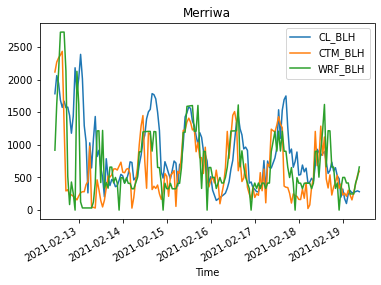

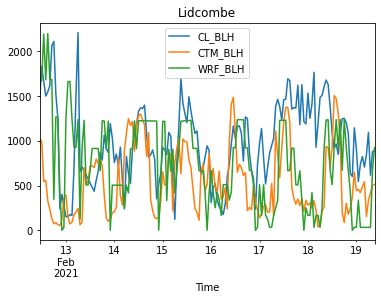

In [6]:
#Plots of Lidcombe and Merriwa BL heights
bl_plot('Merriwa', wrf_df_merriwa)
bl_plot('Lidcombe', wrf_df_lidcombe)

### 1.1 Scraping of air quality data

In [7]:
class AQMS_API:
    def __init__(self):
        self.url_prefix = 'https://data.airquality.nsw.gov.au/api/Data/'
        self.headers = {
            'content-type': 'application/json',
            'accept': 'application/json',
        }
        
        self.site_url = 'get_SiteDetails'
        self.parameter_url = 'get_ParameterDetails'
        self.observation_url = 'get_Observations'
        
    def get_data(self, url_suffix, http_method=requests.get, data=None):
        query = self.url_prefix + url_suffix
        response = http_method(url=query, headers=self.headers, json=data)
        return response.json()
    
    def get_sites(self):
        return self.get_data(self.site_url)
    
    def get_parameters(self):
        return self.get_data(self.parameter_url)
    
    def get_observations(self, data=None):
        return self.get_data(self.observation_url, requests.post, data)

# historical observation query builder
def obs_builder(parameter=None, sites=None, start=None, end=None, category=None, sub_category=None, freq=None):
    '''
    start & end : '%Y-%m-%d' format date string
    '''
    def list_parser(s):
        if s is None or isinstance(s, list):
            return s
        else:
            return [s]

    return {
        'Parameters': list_parser(parameter),
        'Sites': list_parser(sites),
        'StartDate': start,
        'EndDate': end,
        'Categories': list_parser(category),
        'SubCategories': list_parser(sub_category),
        'Frequency': list_parser(freq),
    }

In [8]:
api = AQMS_API()

# site id
sites = {
    'Merriwa': 329,
    'Lidcombe': 1141,
}

In [9]:

df = pd.DataFrame.from_records(api.get_parameters())
params = df.loc[
    (df['Category'] == 'Averages') & 
    (df['SubCategory'] == 'Hourly') & 
    (df['Frequency'] == 'Hourly average')
]

In [10]:
def bl_external(site, site_id):
    query = obs_builder(
        params['ParameterCode'].tolist(), 
        site_id, 
        '2021-02-12',
        '2021-02-20',
        'Averages', 
        'Hourly', 
        'Hourly average'
    )
    obs = pd.DataFrame.from_records(api.get_observations(query))
    obs['Hour'] = obs['Hour'] - 1
    obs['Parameter'] = pd.json_normalize(obs['Parameter'])['ParameterDescription']
    obs = pd.pivot(obs, index=['Date', 'Hour'], columns='Parameter', values='Value').reset_index()
    
    if site == 'Merriwa':
        wrf_df = wrf_df_merriwa
    else:
        wrf_df = wrf_df_lidcombe
    
    df = join_CL_CTM_WRF(site, wrf_df).join(obs.set_index(['Date', 'Hour']), how='inner').reset_index()
    df['BL_diff'] =df['CL_BLH'] - df['CTM_BLH'] 
    return df

In [11]:
#Consolidating all the data in a dict
data = {site: bl_external(site, id) for site, id in sites.items()}

# 2.) Correlation analysis and statistical metrics

### 2.1 Correlation analysis

In [12]:
#Calculating correlation and p-values for the features w.r.t the BL height

def get_df(site):
    if site == 'all':
        df = pd.concat(data.values()).drop(columns='Solar radiation')
    else:
        df = data[site]
    return df.dropna().set_index(['Date', 'Hour'])

def corr(site, method='pearson'):
    return get_df(site).corr(method=method)

from scipy.stats import pearsonr

def p_value(site):
    df = get_df(site)._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues

In [13]:
#Correlation and p values for Lidcombe and Merriwa


#corr('all', 'pearson').iloc[:, :3]
#p_value('all').iloc[:, :3]
#corr('Lidcombe', 'pearson').iloc[:, :3]
#p_value('Lidcombe').iloc[:, :3]
#corr('Merriwa', 'pearson').iloc[:, :3]
#p_value('Merriwa').iloc[:, :3]


### 2.2 Statistical metrics

In [14]:
#Get data from dictionary
df_merriwa = data['Merriwa']
df_lidcombe = data['Lidcombe']

In [15]:
#Interpolating missing values by time
def interpolate_external_factors(df):

    df['datetime'] = pd.to_datetime(df['Date'] +' '+ df['Hour'].astype(str)+':00', format = '%Y-%m-%d %H:%M')

    feature_list_all = [feature for feature in df.columns][4:len(df.columns)-2]

    for feature in feature_list_all:
        df[feature] = df.set_index('datetime')[feature].interpolate(method='time').values
        
    return df

#Creates functions with lags and differences up to d
def create_data_lags(df, d):
    
    df_func = df.copy(deep = True)

    for i in range(d):
        col_name = 'CL_BLH_lag'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].shift(i+1)

    for i in range(d):
        col_name = 'temp'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].diff(periods = i+1)
  
    for i in range(d):
        col_name = 'CL_BLH_diff' + str(i+1)
        target_col = 'temp'+str(i+1)
        df_func[col_name] = df_func[target_col].shift(1)
        
    for i in range(d-1):
        col_name = 'CL_BLH_roll_mean' + str(i+1)
        df_func[col_name] = df_func['CL_BLH'].rolling(i+2).mean().shift(1)
    
    to_drop_list = ['temp1','temp2','temp3','temp4','temp5']
        
    df_func = df_func.drop(to_drop_list, axis = 1)
        
    return df_func

In [16]:
df_merriwa_filled = interpolate_external_factors(df_merriwa)
df_lidcombe_filled = interpolate_external_factors(df_lidcombe)

In [17]:
df_merriwa_wlags = create_data_lags(df_merriwa_filled, 5)
df_lidcombe_wlags = create_data_lags(df_lidcombe_filled, 5)

In [18]:
df_merriwa_wlags

Date  Hour       CL_BLH    CTM_BLH  WRF_BLH  Carbon monoxide  \
0    2021-02-12    11  1782.971698  2116.5154   918.04        -0.013024   
1    2021-02-12    12  2060.904255  2268.4509  1629.29        -0.003834   
2    2021-02-12    13  1942.894737  2332.6211  2124.96        -0.004704   
3    2021-02-12    14  1684.731183  2376.4629  2726.00        -0.003592   
4    2021-02-12    15  1573.967391  2432.8503  2727.78        -0.002880   
..          ...   ...          ...        ...      ...              ...   
161  2021-02-19     5   264.802803   156.5146   247.39        -0.033830   
162  2021-02-19     6   271.336676   271.2063   247.39        -0.035252   
163  2021-02-19     7   283.446311   402.5884   416.71        -0.032138   
164  2021-02-19     8   295.176486   530.2465   503.35        -0.027304   
165  2021-02-19     9   282.303491   596.1211   661.07        -0.031719   

     Humidity  Nephelometer   Nitric Oxide  Nitrogen Dioxide  ...  \
0      47.927          0.042     -0.023461          0.069158  ...   
1      46.820          0.051     -0.015987          0.076345  ...   
2      45.996          0.058     -0.011745          0.066663  ...   
3      44.181          0.060     -0.026188          0.057879  ...   
4      43.716          0.065     -0.021037          0.052190  ...   
..        ...            ...           ...               ...  ...   
161    91.658          0.102     -0.022306          0.170322  ...   
162    91.979          0.105     -0.011042          0.139426  ...   
163    92.351          0.099      0.039190          0.266695  ...   
164    92.986          0.131      0.079679          0.325995  ...   
165    90.363          0.121      0.211296          0.377421  ...   

     CL_BLH_lag5  CL_BLH_diff1  CL_BLH_diff2  CL_BLH_diff3  CL_BLH_diff4  \
0            NaN           NaN           NaN           NaN           NaN   
1            NaN           NaN           NaN           NaN           NaN   
2            NaN    277.932557           NaN           NaN           NaN   
3            NaN   -118.009518    159.923039           NaN           NaN   
4            NaN   -258.163554   -376.173073    -98.240515           NaN   
..           ...           ...           ...           ...           ...   
161   322.490067     46.731527    197.027280    122.500602    -24.570602   
162   175.418863    -33.116662     13.614865    163.910618     89.383939   
163   100.892185      6.533873    -26.582789     20.148738    170.444491   
164   251.187938     12.109635     18.643508    -14.473154     32.258373   
165   297.919465     11.730175     23.839810     30.373683     -2.742979   

     CL_BLH_diff5  CL_BLH_roll_mean1  CL_BLH_roll_mean2  CL_BLH_roll_mean3  \
0             NaN                NaN                NaN                NaN   
1             NaN                NaN                NaN                NaN   
2             NaN        1921.937977                NaN                NaN   
3             NaN        2001.899496        1928.923563                NaN   
4             NaN        1813.812960        1896.176725        1867.875468   
..            ...                ...                ...                ...   
161     98.876668         274.553701         216.666529         206.354613   
162    -57.687264         281.361134         271.303402         228.700598   
163     95.917813         268.069739         278.019648         271.311720   
164    182.554126         277.391494         273.195263         279.376314   
165     43.988548         289.311399         283.319824         278.690569   

     CL_BLH_roll_mean4  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
..                 ...  
161         229.581704  
162         218.044251  
163         237.227813  
164         273.738639  
165         282.536348  

[166 rows x 35 columns]

In [19]:
#Index of agreement(model prediction error)
def index_agreement(s, o):
    """
    Willmott index of agreement

    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

#mean bias error
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

#mean absolute squared error
def MASE(training_series, testing_series, prediction_series):

    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

#DTW distance(Dynamic Time Warping)
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def DTW_dist(y_true, y_pred):
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    
    return distance, path

#pearson correlation
def pearson_corr(y_true, y_pred):
    corr = pearsonr(y_true, y_pred)
    return corr[0]

#Function to calculate and print out metrics

def statistical_metrics_on_df(y_true, y_pred, train_series, location):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    mase = MASE(train_series, y_pred, y_true)
    pears = pearson_corr(y_true, y_pred)
    print('At %s\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f\nMASE:%.5f\nPearson correlation:%.3f' % (location, ioa, rmse, mae, mbe, dtw_dist, mase, pears))

In [20]:
statistical_metrics_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa CTM model')

At Merriwa CTM model
Index of agreement:0.83320
Root mean squared error:212.95909
Mean absoluate error:171.77558
Mean bias error:-21.58962
DTW distance:3611.44
MASE:0.90875
Pearson correlation:0.697


In [21]:
statistical_metrics_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe CTM model')

At Lidcombe CTM model
Index of agreement:0.39774
Root mean squared error:585.35820
Mean absoluate error:505.07921
Mean bias error:-375.16142
DTW distance:8749.96
MASE:2.29637
Pearson correlation:0.117


In [22]:
statistical_metrics_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa WRF model')

At Merriwa WRF model
Index of agreement:0.71512
Root mean squared error:318.60122
Mean absoluate error:243.62769
Mean bias error:114.60318
DTW distance:4944.59
MASE:1.28888
Pearson correlation:0.621


In [23]:
statistical_metrics_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe WRF model')

At Lidcombe WRF model
Index of agreement:0.52481
Root mean squared error:573.70993
Mean absoluate error:473.14111
Mean bias error:-428.84950
DTW distance:8163.15
MASE:2.15116
Pearson correlation:0.551


# 3.) Regression models

## 3.1 Features and plots

### 3.1.1 Train test split and consideration of all features

In [24]:
feature_list_all = [feature for feature in df_merriwa.columns][5:len(df_merriwa.columns)-2]

In [25]:
#list of all features 
feature_list_all

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ']

In [26]:
#Feature list with lags
feature_list_all_wlags = feature_list_all.copy()
feature_list_all_wlags.extend(['CL_BLH_lag1', 'CL_BLH_lag2','CL_BLH_lag3','CL_BLH_lag4','CL_BLH_lag5'])

#Feature list with lags and BL difference

feature_list_all_ld = feature_list_all_wlags.copy()
feature_list_all_ld.extend(['CL_BLH_diff1', 'CL_BLH_diff2','CL_BLH_diff3','CL_BLH_diff4','CL_BLH_diff5'])

#Feature list with lags, difference and rolling mean
feature_list_all_ldm = feature_list_all_ld.copy()
feature_list_all_ldm.extend(['CL_BLH_roll_mean1', 'CL_BLH_roll_mean2', 'CL_BLH_roll_mean3', 'CL_BLH_roll_mean4'])

feature_list_all_ldm

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ',
 'CL_BLH_lag1',
 'CL_BLH_lag2',
 'CL_BLH_lag3',
 'CL_BLH_lag4',
 'CL_BLH_lag5',
 'CL_BLH_diff1',
 'CL_BLH_diff2',
 'CL_BLH_diff3',
 'CL_BLH_diff4',
 'CL_BLH_diff5',
 'CL_BLH_roll_mean1',
 'CL_BLH_roll_mean2',
 'CL_BLH_roll_mean3',
 'CL_BLH_roll_mean4']

### 3.1.2 Plots

In [27]:
def pred_plots(df, title):
    resid_plot_title = 'Residual plots at '+ title
    pred_plot_title = 'Comparison of predicted BLH at ' + title
    
    sns.set_theme(style="whitegrid")

    # Make an example dataset with y ~ x
    x = df['CL_BLH']
    y = df['Predicted BLH']
    z = df['WRF_BLH']
    
    # Plot the residuals after fitting a linear model
    sns.residplot(x=x, y=y, lowess=True, color="g").set(title = resid_plot_title)
    sns.residplot(x=x, y=z, lowess=True, color="r").set(title = resid_plot_title)
    df.plot(title = pred_plot_title, figsize=(15,10))

### 3.1.3 Statistical metrics result

In [28]:
def results_print(df, train_series, title):
    pred_plots(df, title)
    statistical_metrics_on_df(df['CL_BLH'], df['Predicted BLH'], train_series, title)

## 3.2 Random forest 

### 3.2.1 Random search CV

In [29]:
from sklearn.ensemble import RandomForestRegressor

#Random search CV
def rf_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    rf = RandomForestRegressor(max_depth=60, max_features='sqrt', min_samples_split=5, n_estimators=200)
    rf.fit(X_train, y_train)
    
    #Predict
    
    rf_predict = rf.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  rf_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, rf

In [30]:
#Finding the important features 
def feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.feature_importances_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa RF all features with lags, BL difference and rolling mean
Index of agreement:0.87153
Root mean squared error:174.67484
Mean absoluate error:151.06305
Mean bias error:126.64324
DTW distance:2538.04
MASE:0.79918
Pearson correlation:0.889


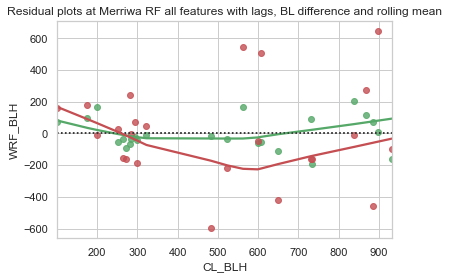

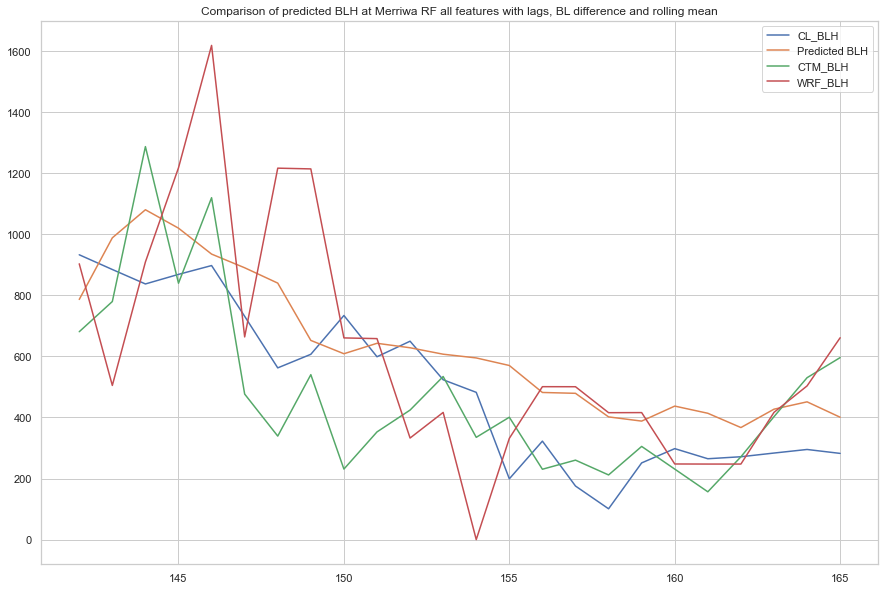

In [31]:
df_rf_merriwa_ld, rf_merriwa_ld = rf_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_rf_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa RF all features with lags, BL difference and rolling mean')

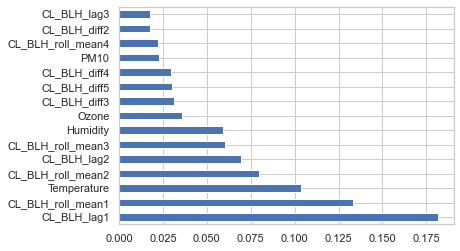

In [32]:
feature_importance_plot(rf_merriwa_ld, feature_list_all_ldm)

In [34]:
from sklearn.ensemble import RandomForestRegressor

#Random search CV
def rf_modellerL(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    rf = RandomForestRegressor(max_depth=90, min_samples_split=10, n_estimators=1600)
    rf.fit(X_train, y_train)
    
    #Predict
    
    rf_predict = rf.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  rf_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, rf

At Lidcombe RF all features with lags, BL difference and rolling mean
Index of agreement:0.73708
Root mean squared error:243.58321
Mean absoluate error:195.65733
Mean bias error:45.78808
DTW distance:1831.15
MASE:0.88957
Pearson correlation:0.548


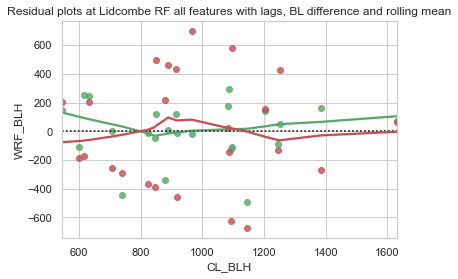

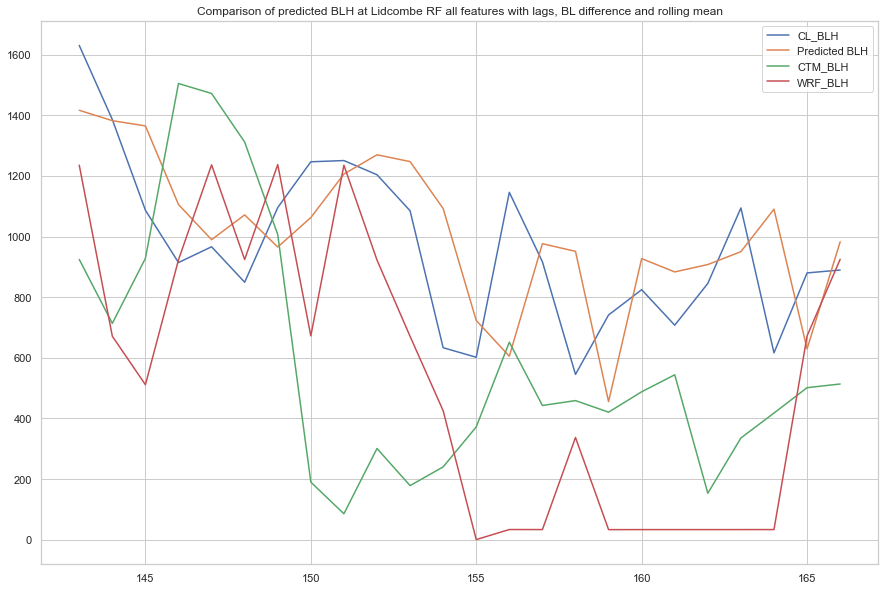

In [35]:
df_rf_lidcombe_ld, rf_lidcombe_ld = rf_modellerL(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_rf_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe RF all features with lags, BL difference and rolling mean')

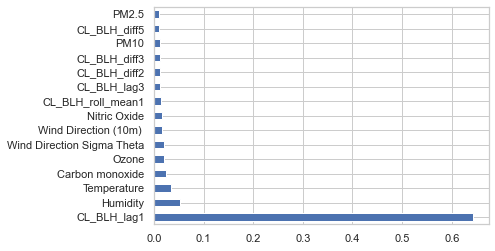

In [36]:
feature_importance_plot(rf_lidcombe_ld, feature_list_all_ldm)

### 3.2.2 Grid search CV

In [37]:
#Grid search CV
def rf_modeller1(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    rf = RandomForestRegressor(max_depth=70, max_features='sqrt', n_estimators=400, min_samples_leaf=2)
    rf.fit(X_train, y_train)
    
    #Predict
    
    rf_predict = rf.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  rf_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, rf

At Merriwa RF all features with lags, BL difference and rolling mean
Index of agreement:0.88008
Root mean squared error:169.86107
Mean absoluate error:145.67936
Mean bias error:122.00316
DTW distance:2472.16
MASE:0.77069
Pearson correlation:0.892


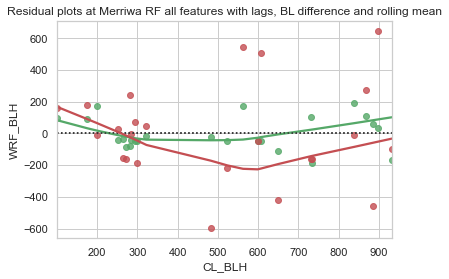

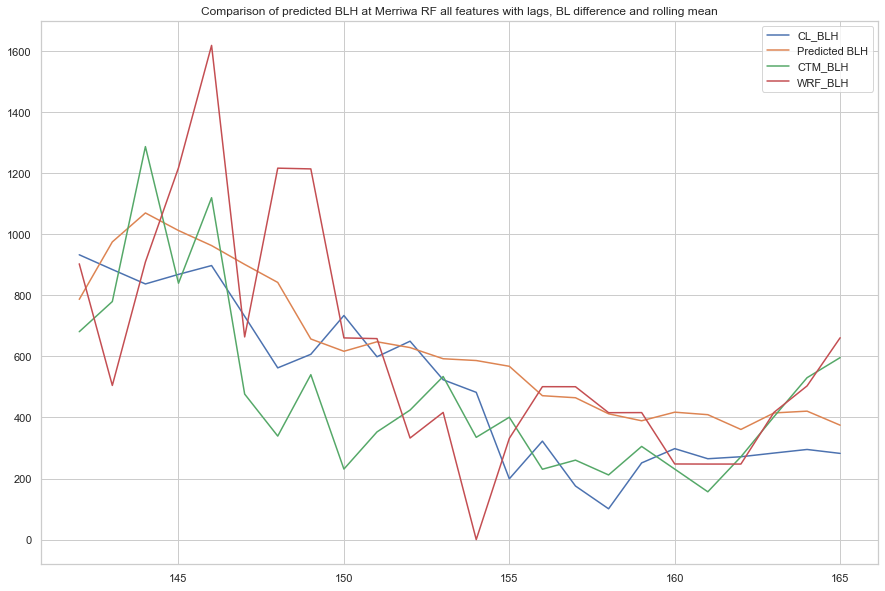

In [38]:
df_rf_merriwa_ld1, rf_merriwa_ld1 = rf_modeller1(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_rf_merriwa_ld1, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa RF all features with lags, BL difference and rolling mean')

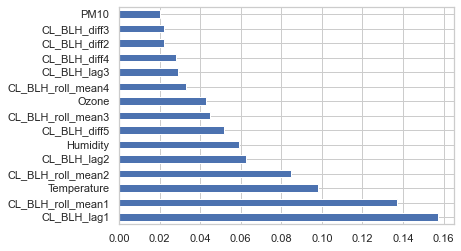

In [39]:
feature_importance_plot(rf_merriwa_ld1, feature_list_all_ldm)

In [40]:
#Grid search CV
def rf_modeller1L(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    rf = RandomForestRegressor(max_depth=80, n_estimators=400)
    rf.fit(X_train, y_train)
    
    #Predict
    
    rf_predict = rf.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  rf_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, rf

At Lidcombe RF all features with lags, BL difference and rolling mean
Index of agreement:0.73874
Root mean squared error:244.71466
Mean absoluate error:194.88153
Mean bias error:46.42857
DTW distance:1811.93
MASE:0.88604
Pearson correlation:0.547


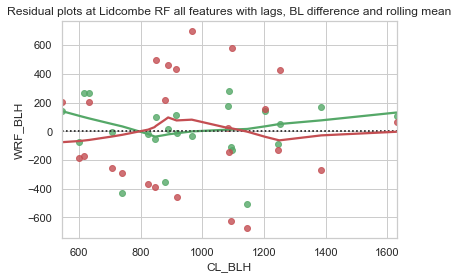

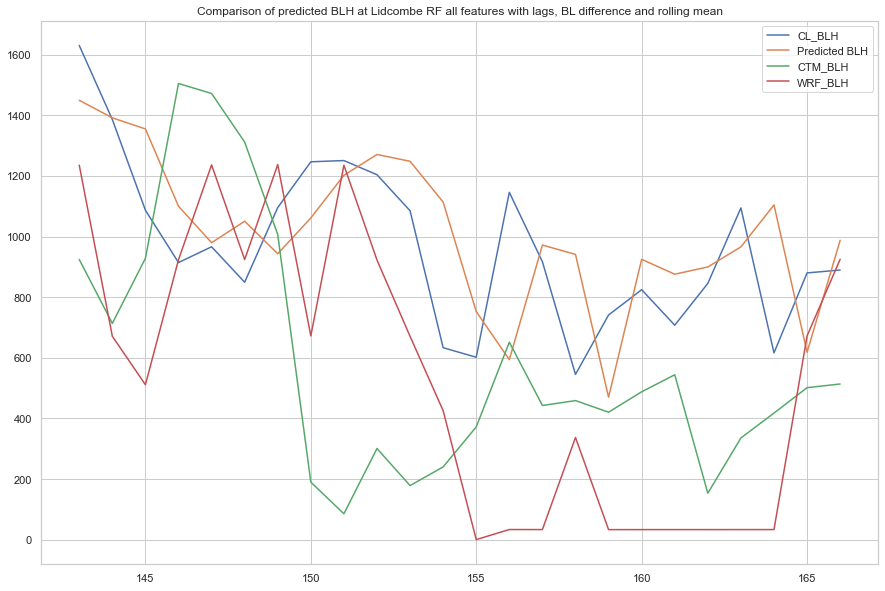

In [41]:
df_rf_lidcombe_ld1, rf_lidcombe_ld1 = rf_modeller1L(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_rf_lidcombe_ld1, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe RF all features with lags, BL difference and rolling mean')

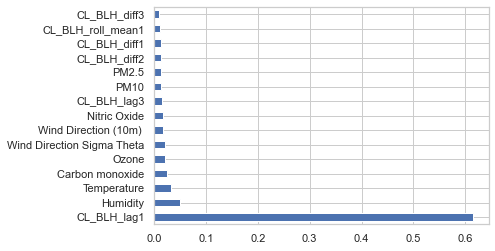

In [42]:
feature_importance_plot(rf_lidcombe_ld1, feature_list_all_ldm)

## 3.3 SVR 

### 3.3.1 Random search CV

In [43]:
from sklearn import svm

#Random search cv
def svm_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    vreg = svm.LinearSVR(C=10, epsilon=0.3, fit_intercept=False, loss='squared_epsilon_insensitive')
    vreg.fit(X_train, y_train)
    
    #Predict
    
    vreg_predict = vreg.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  vreg_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, vreg

In [44]:
#Finding the important features for SVR
def svm_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


At Merriwa SVR all features with lags, BL difference and rolling mean
Index of agreement:0.91750
Root mean squared error:149.97506
Mean absoluate error:122.47388
Mean bias error:92.92949
DTW distance:1714.25
MASE:0.64793
Pearson correlation:0.899


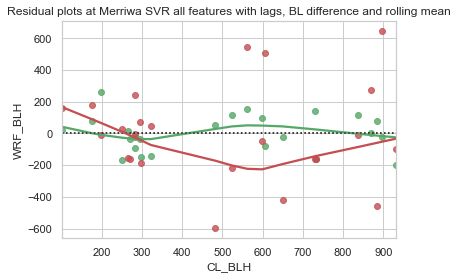

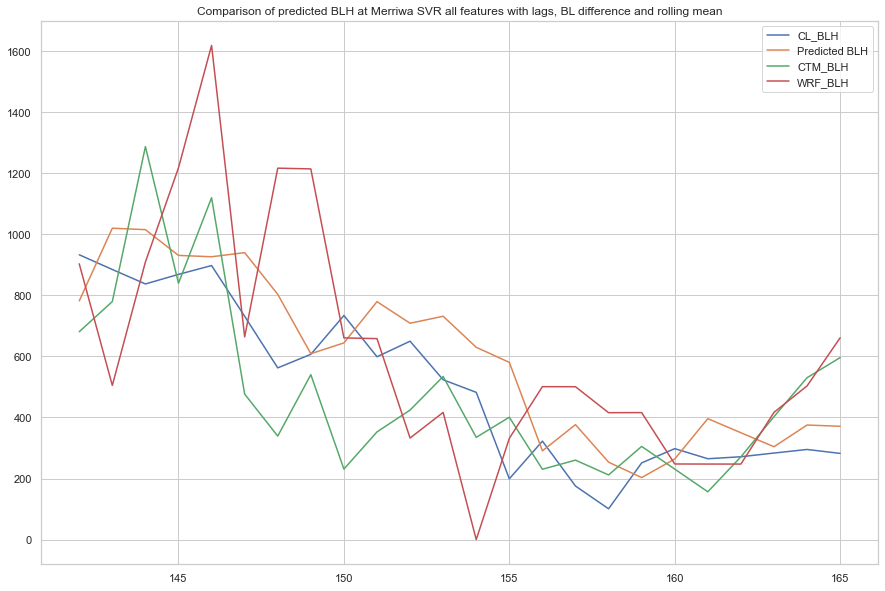

In [45]:
df_vreg_merriwa_ld, vreg_merriwa_ld = svm_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_vreg_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa SVR all features with lags, BL difference and rolling mean')

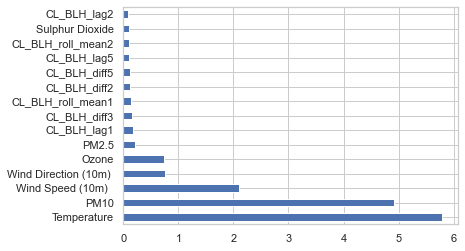

In [46]:
svm_feature_importance_plot(vreg_merriwa_ld, feature_list_all_ldm)

In [48]:
from sklearn import svm

#Random search cv
def svm_modellerL(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    vreg = svm.LinearSVR(C=1.5, epsilon=0.5, loss='squared_epsilon_insensitive')
    vreg.fit(X_train, y_train)
    
    #Predict
    
    vreg_predict = vreg.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  vreg_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, vreg

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


At Lidcombe SVR all features with lags, BL difference and rolling mean
Index of agreement:0.59524
Root mean squared error:468.09037
Mean absoluate error:413.16484
Mean bias error:402.35920
DTW distance:7163.15
MASE:1.87848
Pearson correlation:0.663


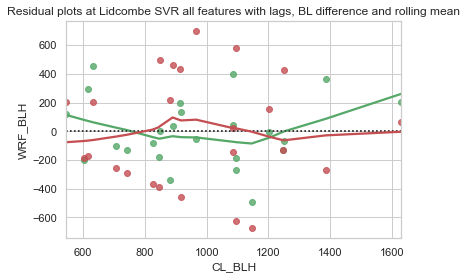

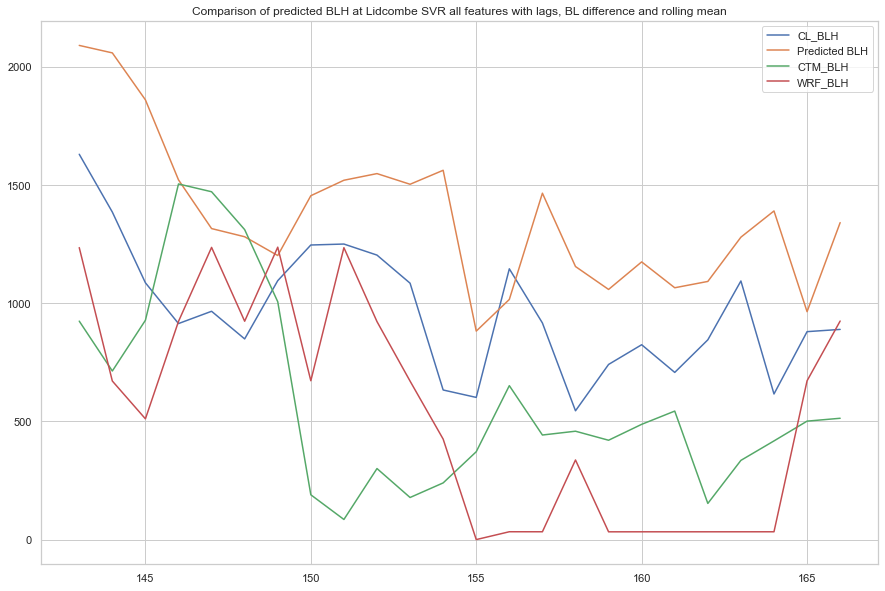

In [49]:
df_vreg_lidcombe_ld, vreg_lidcombe_ld = svm_modellerL(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_vreg_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe SVR all features with lags, BL difference and rolling mean')

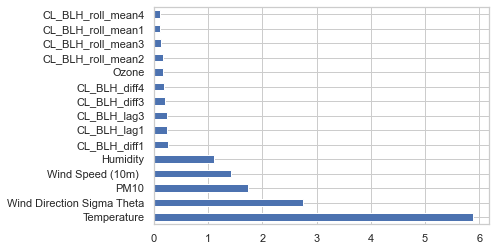

In [50]:
svm_feature_importance_plot(vreg_lidcombe_ld, feature_list_all_ldm)

### 3.3.2 Grid search CV

In [51]:
#Grid search CV
def svm_modeller1(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    vreg = svm.LinearSVR(C=1.5, epsilon=0.1, fit_intercept=False)
    vreg.fit(X_train, y_train)
    
    #Predict
    
    vreg_predict = vreg.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  vreg_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, vreg

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


At Merriwa SVR all features with lags, BL difference and rolling mean
Index of agreement:0.91363
Root mean squared error:132.56251
Mean absoluate error:99.21226
Mean bias error:41.65457
DTW distance:1567.17
MASE:0.52487
Pearson correlation:0.884


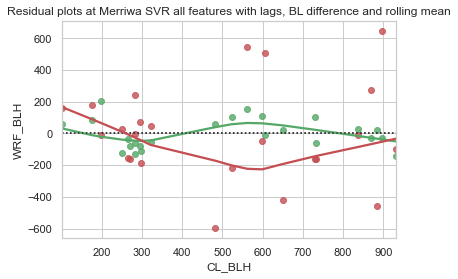

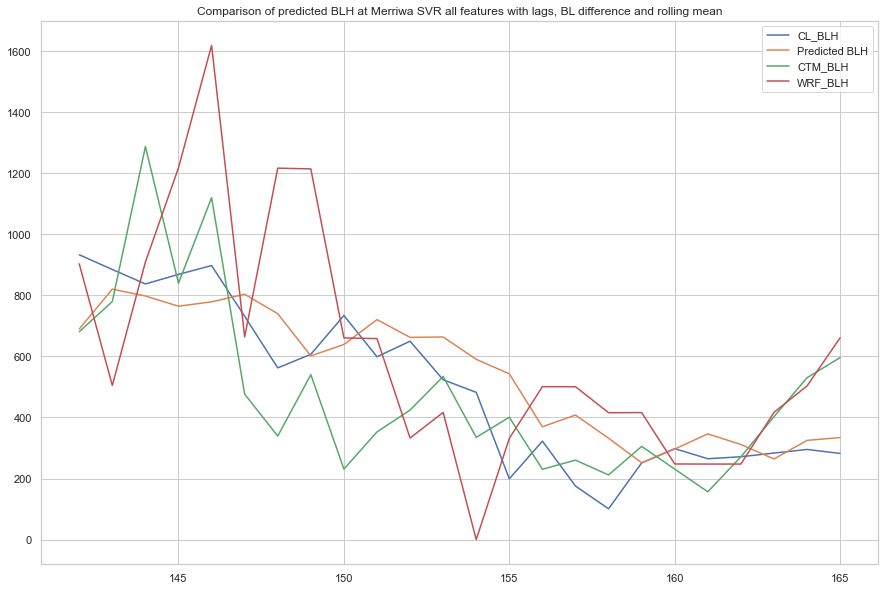

In [52]:
df_vreg_merriwa_ld1, vreg_merriwa_ld1 = svm_modeller1(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_vreg_merriwa_ld1, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa SVR all features with lags, BL difference and rolling mean')

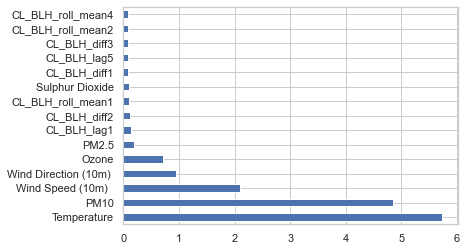

In [53]:
svm_feature_importance_plot(vreg_merriwa_ld1, feature_list_all_ldm)

In [54]:
#Grid search CV
def svm_modeller1L(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    vreg = svm.LinearSVR(C=10, epsilon=0.2)
    vreg.fit(X_train, y_train)
    
    #Predict
    
    vreg_predict = vreg.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  vreg_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, vreg

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


At Lidcombe SVR all features with lags, BL difference and rolling mean
Index of agreement:0.57106
Root mean squared error:549.94329
Mean absoluate error:476.26173
Mean bias error:449.07281
DTW distance:8824.46
MASE:2.16535
Pearson correlation:0.611


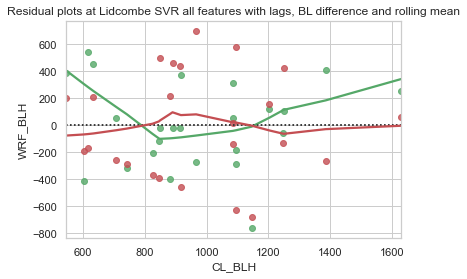

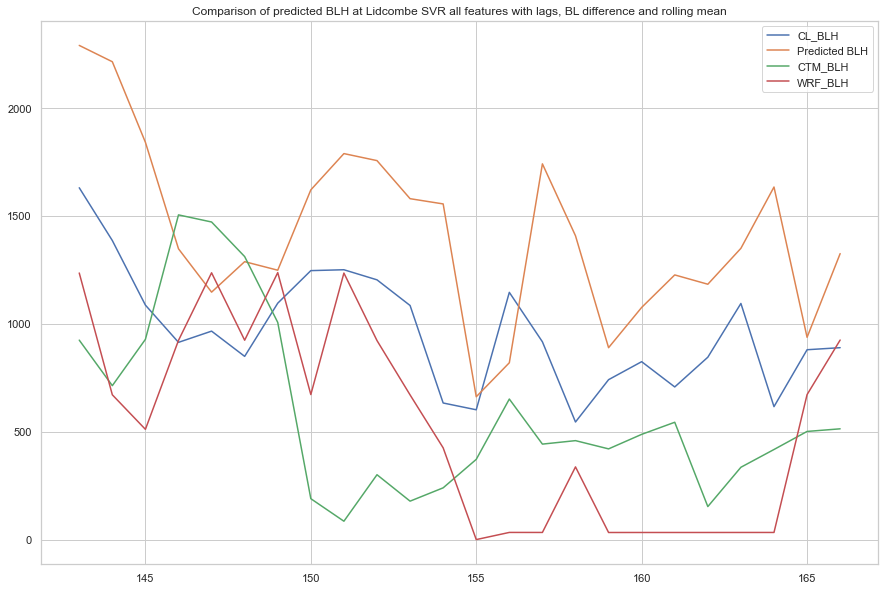

In [55]:
df_vreg_lidcombe_ld1, vreg_lidcombe_ld1 = svm_modeller1L(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_vreg_lidcombe_ld1, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe SVR all features with lags, BL difference and rolling mean')

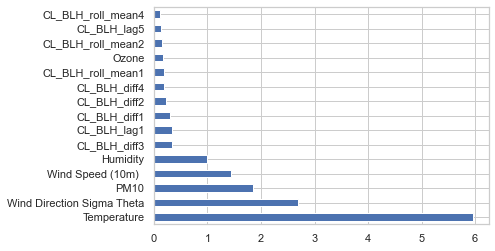

In [56]:
svm_feature_importance_plot(vreg_lidcombe_ld1, feature_list_all_ldm)

## 3.4 Multiple linear regression 

### 3.4.1 Random search and Grid search CV

Both yielded same hyperparameters

In [57]:
from sklearn.linear_model import LinearRegression

def mulin_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    mulin = LinearRegression(fit_intercept = False, n_jobs=1, normalize=True)
    mulin.fit(X_train, y_train)
    
    #Predict
    
    mulin_predict = mulin.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  mulin_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, mulin

In [58]:
#Finding the important features for multiple linear regression
def mulin_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa MLR all features with lags, BL difference and rolling mean
Index of agreement:0.85183
Root mean squared error:172.38102
Mean absoluate error:139.65855
Mean bias error:103.47265
DTW distance:1813.48
MASE:0.73884
Pearson correlation:0.866


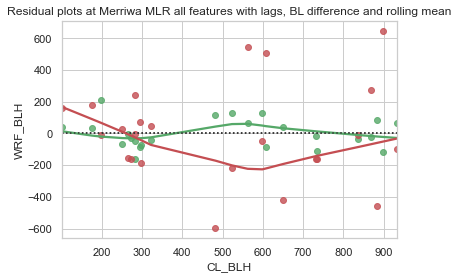

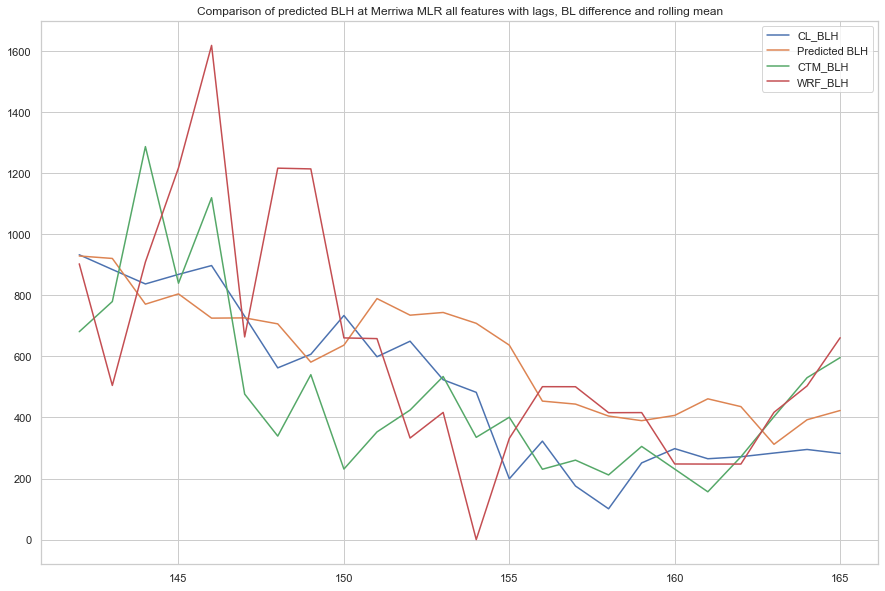

In [59]:
df_mulin_merriwa_ld, mulin_merriwa_ld = mulin_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_mulin_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa MLR all features with lags, BL difference and rolling mean')

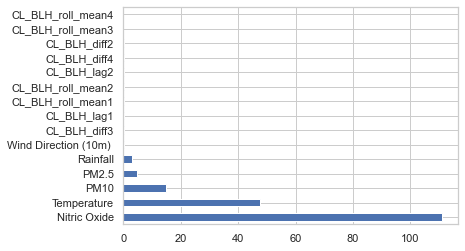

In [60]:
mulin_feature_importance_plot(mulin_merriwa_ld, feature_list_all_ldm)

In [61]:
from sklearn.linear_model import LinearRegression

def mulin_modellerL(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    mulin = LinearRegression(n_jobs=1, normalize=True)
    mulin.fit(X_train, y_train)
    
    #Predict
    
    mulin_predict = mulin.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  mulin_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, mulin

At Lidcombe MLR all features with lags, BL difference and rolling mean
Index of agreement:0.63084
Root mean squared error:260.36715
Mean absoluate error:215.77366
Mean bias error:96.86397
DTW distance:2986.20
MASE:0.98103
Pearson correlation:0.434


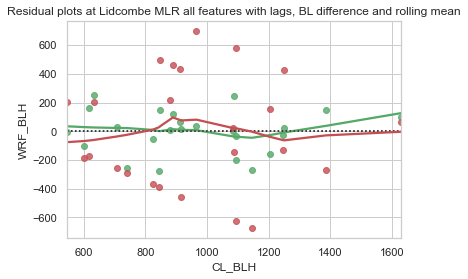

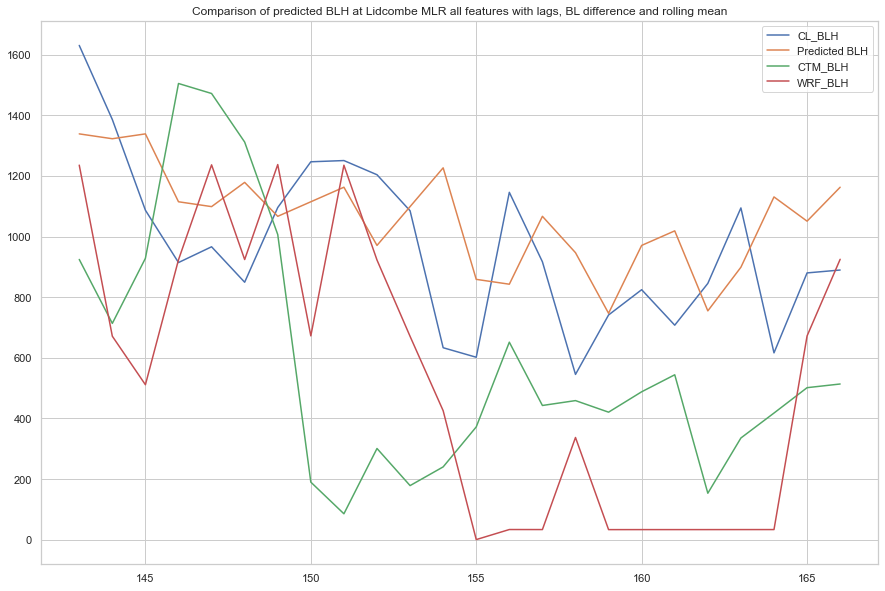

In [62]:
df_mulin_lidcombe_ld, mulin_lidcombe_ld = mulin_modellerL(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_mulin_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe MLR all features with lags, BL difference and rolling mean')

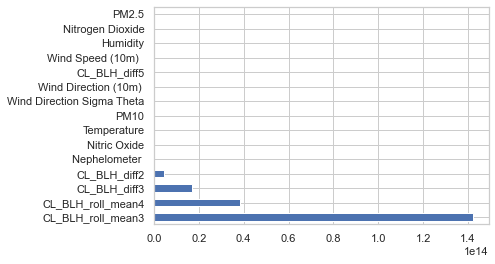

In [63]:
mulin_feature_importance_plot(mulin_lidcombe_ld, feature_list_all_ldm)

## 3.5 Decision tree 

### 3.5.1 Random search CV

In [64]:
from sklearn.tree import DecisionTreeRegressor

#Random search CV
def tree_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    dtree = DecisionTreeRegressor(max_features='log2', min_samples_leaf=6)
    dtree.fit(X_train, y_train)
    
    #Predict
    
    dtree_predict = dtree.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  dtree_predict
    df_result['CTM_BLH'] = test['CTM_BLH']
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, dtree

In [65]:
#Finding the important features for Decision Tree regression
def dtree_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.feature_importances_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa Decision Tree all features with lags, BL difference and rolling mean
Index of agreement:0.72785
Root mean squared error:222.84509
Mean absoluate error:186.44612
Mean bias error:122.72345
DTW distance:2597.67
MASE:0.98637
Pearson correlation:0.712


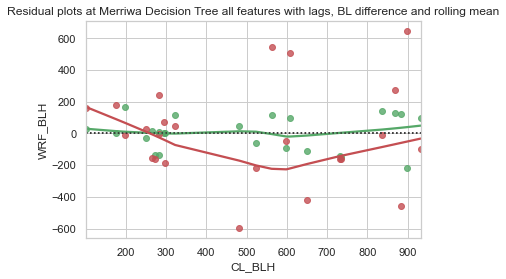

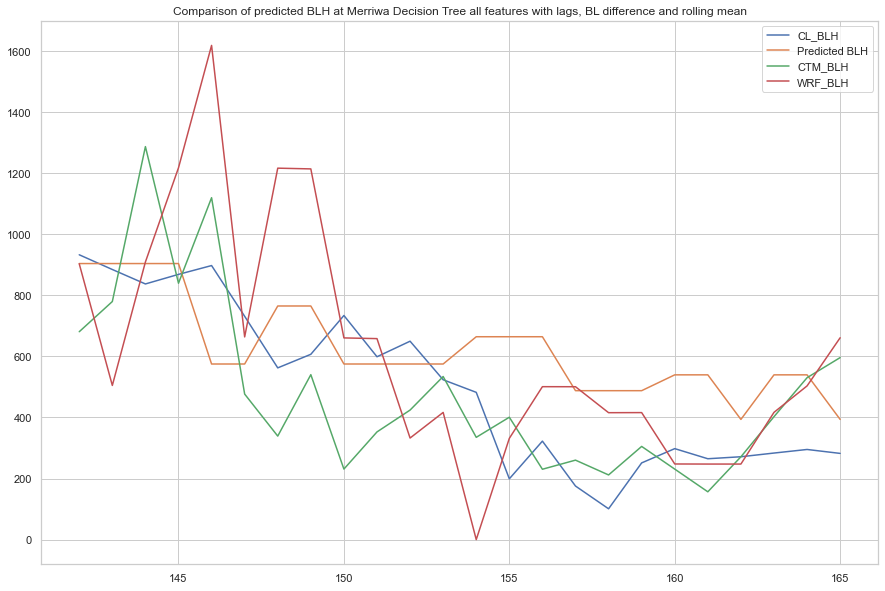

In [66]:
df_dtree_merriwa_ld, dtree_merriwa_ld = tree_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_dtree_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa Decision Tree all features with lags, BL difference and rolling mean')

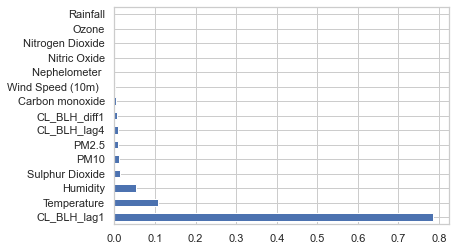

In [67]:
dtree_feature_importance_plot(dtree_merriwa_ld, feature_list_all_ldm)

In [68]:
from sklearn.tree import DecisionTreeRegressor

#Random search CV
def tree_modellerL(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    dtree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2, max_features='log2', min_samples_leaf=3)
    dtree.fit(X_train, y_train)
    
    #Predict
    
    dtree_predict = dtree.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  dtree_predict
    df_result['CTM_BLH'] = test['CTM_BLH']
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, dtree

At Lidcombe Decision Tree all features with lags, BL difference and rolling mean
Index of agreement:0.64958
Root mean squared error:286.04334
Mean absoluate error:231.22430
Mean bias error:-69.92426
DTW distance:4075.32
MASE:1.05127
Pearson correlation:0.379


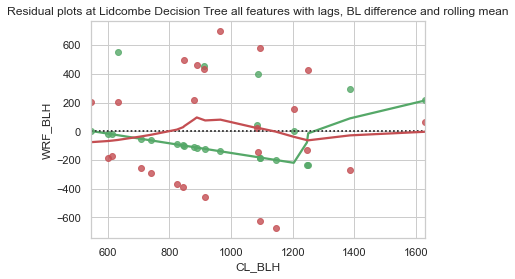

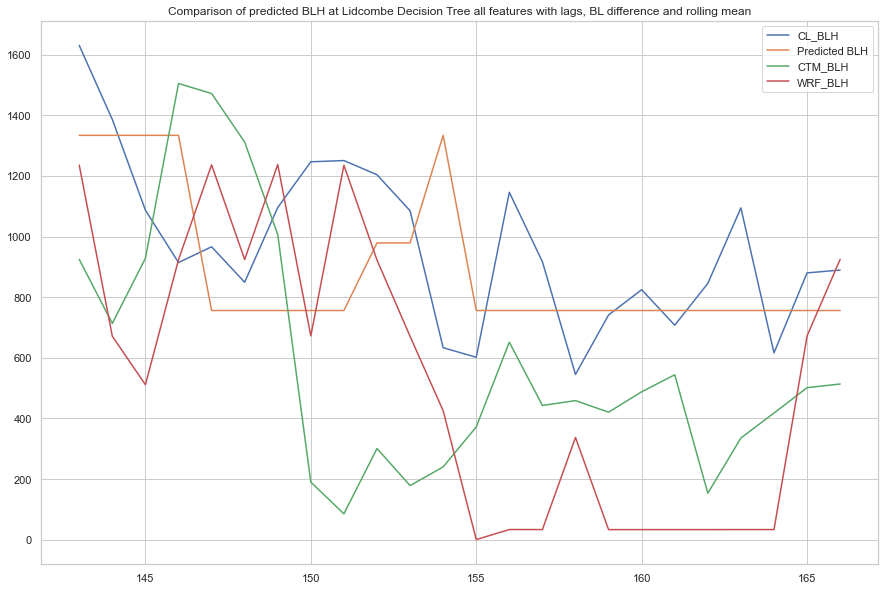

In [69]:
df_dtree_lidcombe_ld, dtree_lidcombe_ld = tree_modellerL(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_dtree_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe Decision Tree all features with lags, BL difference and rolling mean')

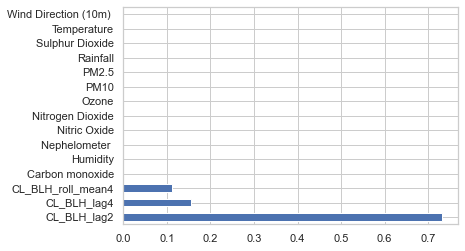

In [70]:
dtree_feature_importance_plot(dtree_lidcombe_ld, feature_list_all_ldm)

### 3.5.2 Grid search CV

In [71]:
from sklearn.tree import DecisionTreeRegressor

#Grid search CV
def tree_modeller1(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    dtree = DecisionTreeRegressor(criterion='friedman_mse', max_features='sqrt', min_samples_leaf=9, max_depth=3)
    dtree.fit(X_train, y_train)
    
    #Predict
    
    dtree_predict = dtree.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  dtree_predict
    df_result['CTM_BLH'] = test['CTM_BLH']
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, dtree

At Merriwa Decision Tree all features with lags, BL difference and rolling mean
Index of agreement:0.74152
Root mean squared error:273.48700
Mean absoluate error:235.97506
Mean bias error:216.40064
DTW distance:2351.51
MASE:1.24839
Pearson correlation:0.772


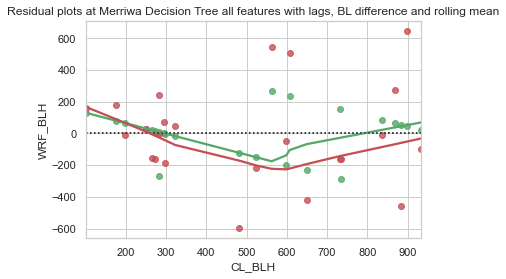

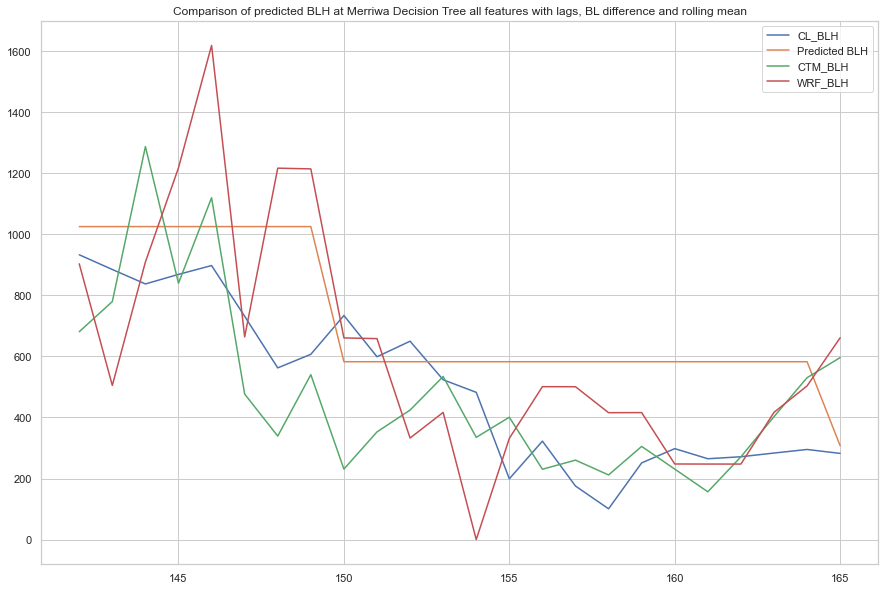

In [72]:
df_dtree_merriwa_ld1, dtree_merriwa_ld1 = tree_modeller1(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_dtree_merriwa_ld1, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa Decision Tree all features with lags, BL difference and rolling mean')

Plot looks stupid as.. Shouldn't make decisions based on just the stats, look at the plots as well. 

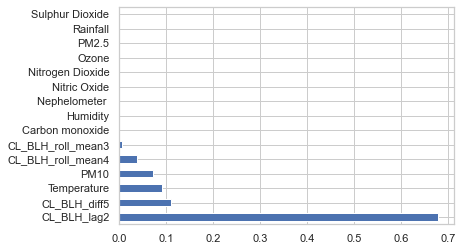

In [73]:
dtree_feature_importance_plot(dtree_merriwa_ld1, feature_list_all_ldm)

In [74]:
from sklearn.tree import DecisionTreeRegressor

#Grid search CV
def tree_modeller1L(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    dtree = DecisionTreeRegressor(max_features='sqrt', min_samples_leaf=8, max_depth=3)
    dtree.fit(X_train, y_train)
    
    #Predict
    
    dtree_predict = dtree.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  dtree_predict
    df_result['CTM_BLH'] = test['CTM_BLH']
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, dtree

At Lidcombe Decision Tree all features with lags, BL difference and rolling mean
Index of agreement:0.59382
Root mean squared error:341.98919
Mean absoluate error:272.52549
Mean bias error:-2.34423
DTW distance:3765.83
MASE:1.23905
Pearson correlation:0.304


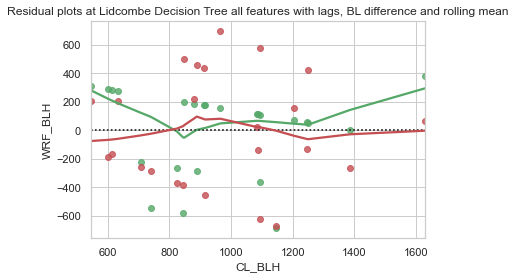

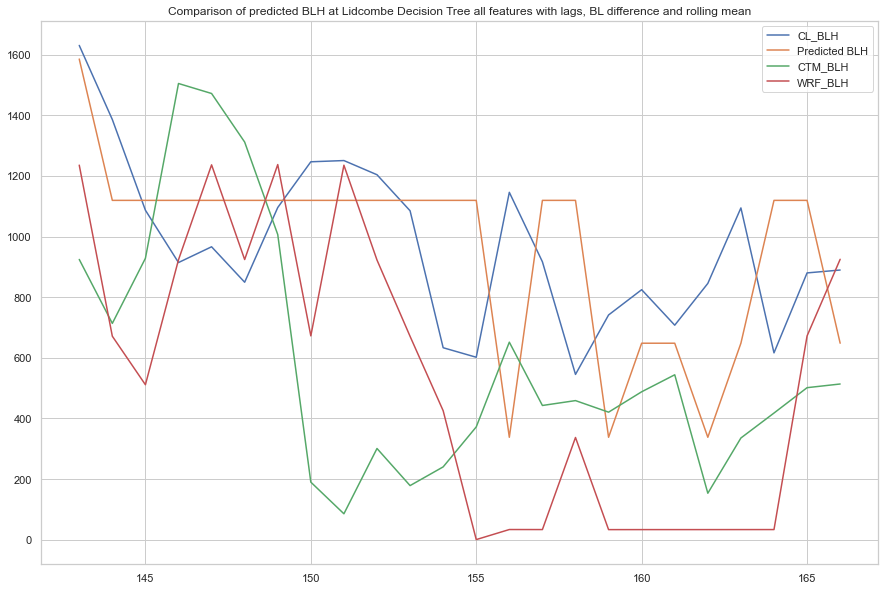

In [75]:
df_dtree_lidcombe_ld1, dtree_lidcombe_ld1 = tree_modeller1L(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_dtree_lidcombe_ld1, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe Decision Tree all features with lags, BL difference and rolling mean')

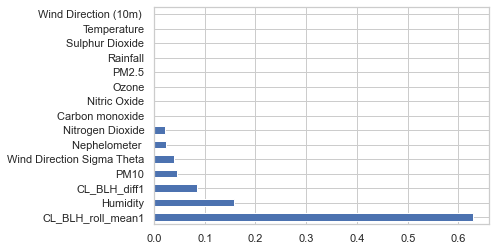

In [76]:
dtree_feature_importance_plot(dtree_lidcombe_ld1, feature_list_all_ldm)

## 3.6 Lasso regression 

### 3.6.1 Random search CV

In [77]:
from sklearn.linear_model import Lasso

#Random search CV
def lasso_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    lasso = Lasso(alpha=2, max_iter=1600, normalize=True, selection='random', tol=1e-06)
    lasso.fit(X_train, y_train)
    
    #Predict
    
    lasso_predict = lasso.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  lasso_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, lasso

In [78]:
#Finding the important features for Lasso regression
def lasso_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa Lasso all features with lags, BL difference and rolling mean
Index of agreement:0.88599
Root mean squared error:170.48351
Mean absoluate error:146.63215
Mean bias error:138.22054
DTW distance:2238.30
MASE:0.77574
Pearson correlation:0.925


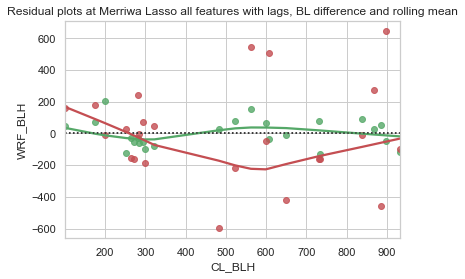

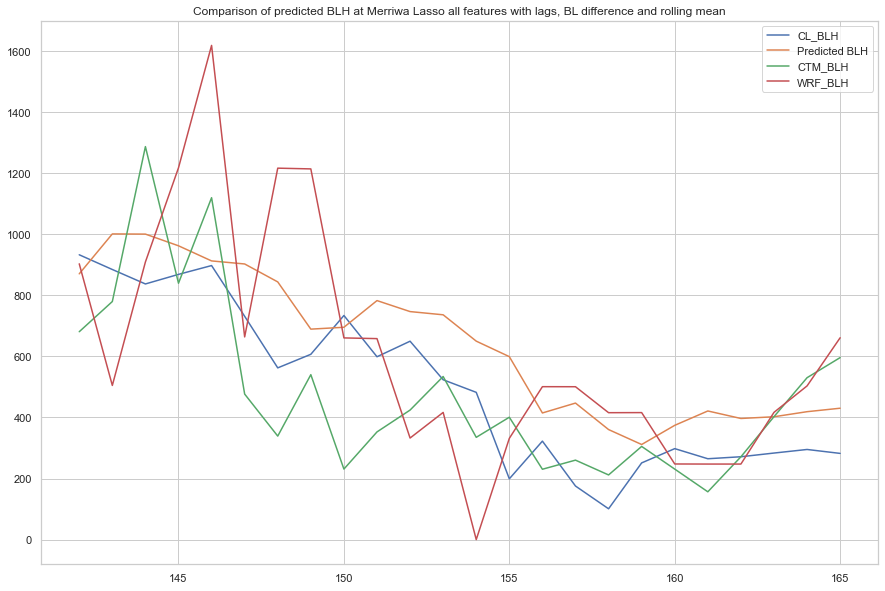

In [79]:
df_lasso_merriwa_ld, lasso_merriwa_ld = lasso_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_lasso_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa Lasso all features with lags, BL difference and rolling mean')

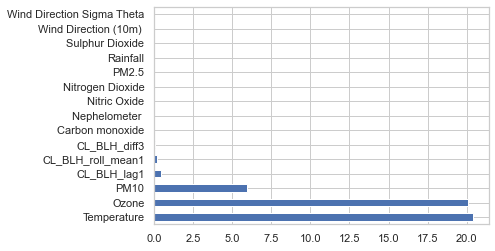

In [80]:
lasso_feature_importance_plot(lasso_merriwa_ld, feature_list_all_ldm)

In [81]:
from sklearn.linear_model import Lasso

#Random search CV
def lasso_modellerL(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    lasso = Lasso(alpha=5, copy_X=False, max_iter=1600, normalize=True, tol=0.001)
    lasso.fit(X_train, y_train)
    
    #Predict
    
    lasso_predict = lasso.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  lasso_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, lasso

At Lidcombe Lasso all features with lags, BL difference and rolling mean
Index of agreement:0.79720
Root mean squared error:194.95247
Mean absoluate error:161.77483
Mean bias error:-1.74296
DTW distance:2595.05
MASE:0.73552
Pearson correlation:0.672


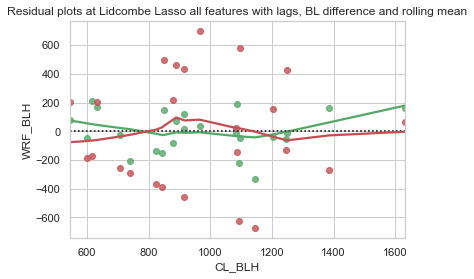

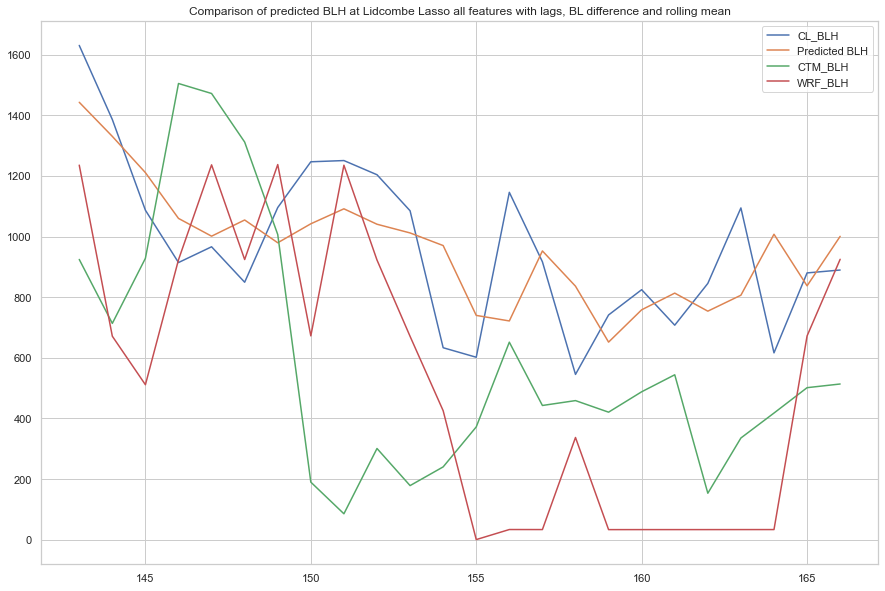

In [82]:
df_lasso_lidcombe_ld, lasso_lidcombe_ld = lasso_modellerL(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_lasso_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe Lasso all features with lags, BL difference and rolling mean')

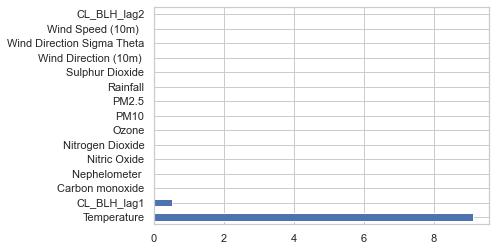

In [83]:
lasso_feature_importance_plot(lasso_lidcombe_ld, feature_list_all_ldm)

### 3.6.2 Grid search CV

In [84]:
from sklearn.linear_model import Lasso

#Grid search CV
def lasso_modeller1(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    lasso = Lasso(alpha=2, copy_X=False, max_iter=1200, normalize=True, selection='random', tol=0.001)
    lasso.fit(X_train, y_train)
    
    #Predict
    
    lasso_predict = lasso.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  lasso_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, lasso

At Merriwa Lasso all features with lags, BL difference and rolling mean
Index of agreement:0.88537
Root mean squared error:171.01641
Mean absoluate error:147.60360
Mean bias error:138.35713
DTW distance:2260.68
MASE:0.78087
Pearson correlation:0.924


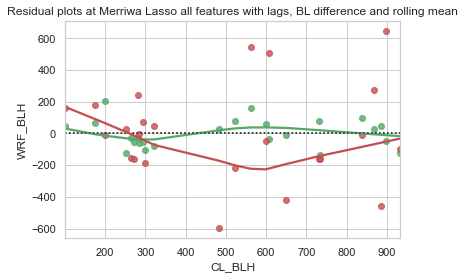

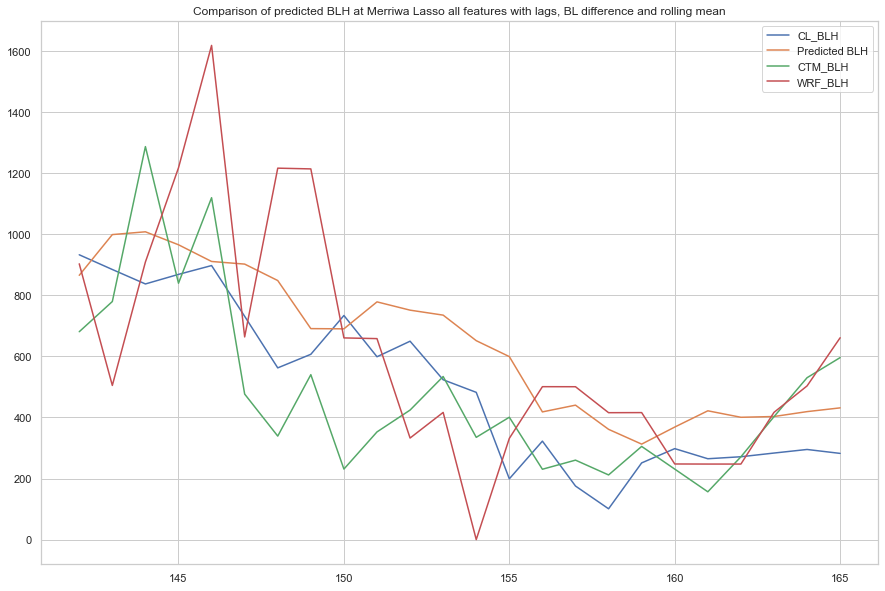

In [85]:
df_lasso_merriwa_ld1, lasso_merriwa_ld1 = lasso_modeller1(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_lasso_merriwa_ld1, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa Lasso all features with lags, BL difference and rolling mean')

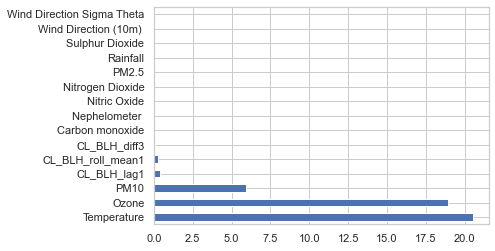

In [86]:
lasso_feature_importance_plot(lasso_merriwa_ld1, feature_list_all_ldm)

In [87]:
from sklearn.linear_model import Lasso

#Grid search CV
def lasso_modeller1L(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    lasso = Lasso(alpha=5, max_iter=1400, normalize=True, selection='random', tol=0.001)
    lasso.fit(X_train, y_train)
    
    #Predict
    
    lasso_predict = lasso.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  lasso_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, lasso

At Lidcombe Lasso all features with lags, BL difference and rolling mean
Index of agreement:0.79719
Root mean squared error:194.95439
Mean absoluate error:161.77428
Mean bias error:-1.71813
DTW distance:2595.11
MASE:0.73552
Pearson correlation:0.672


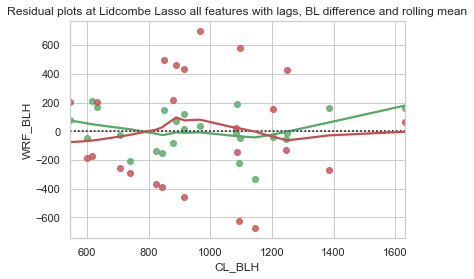

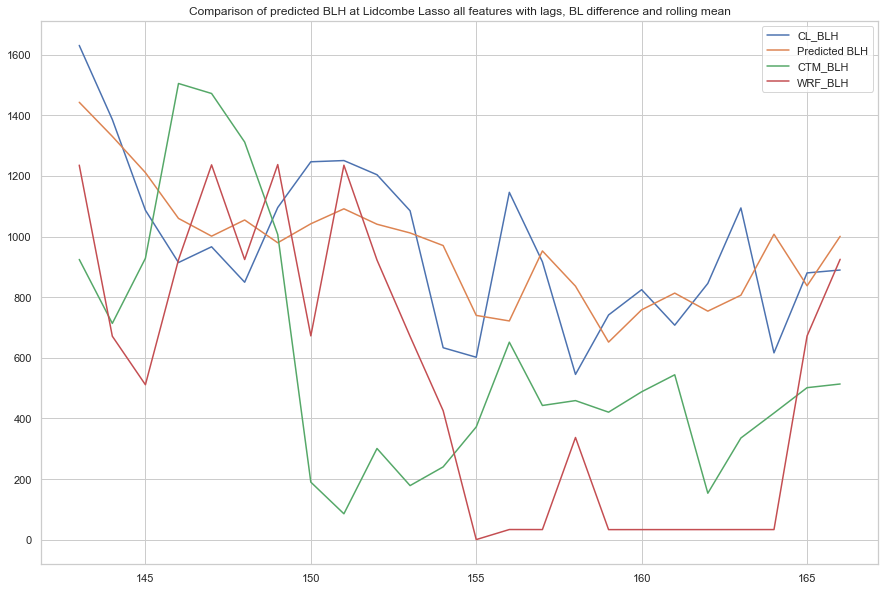

In [88]:
df_lasso_lidcombe_ld1, lasso_lidcombe_ld1 = lasso_modeller1L(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_lasso_lidcombe_ld1, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe Lasso all features with lags, BL difference and rolling mean')

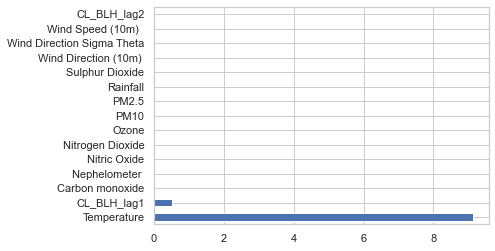

In [89]:
lasso_feature_importance_plot(lasso_lidcombe_ld1, feature_list_all_ldm)

## 3.7 Ridge regression 

### 3.7.1 Random search CV

In [90]:
from sklearn.linear_model import Ridge

#Random search CV
def ridge_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    ridge = Ridge(alpha=1, copy_X=False, max_iter=1200, solver='sag')
    ridge.fit(X_train, y_train)
    
    #Predict
    
    ridge_predict = ridge.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  ridge_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, ridge

In [91]:
#Finding the important features for Ridge regression
def ridge_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa Ridge all features with lags, BL difference and rolling mean
Index of agreement:0.92550
Root mean squared error:134.32107
Mean absoluate error:108.30447
Mean bias error:81.11767
DTW distance:1553.73
MASE:0.57297
Pearson correlation:0.912


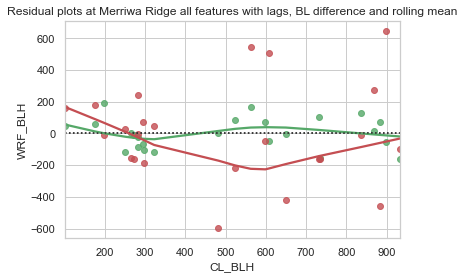

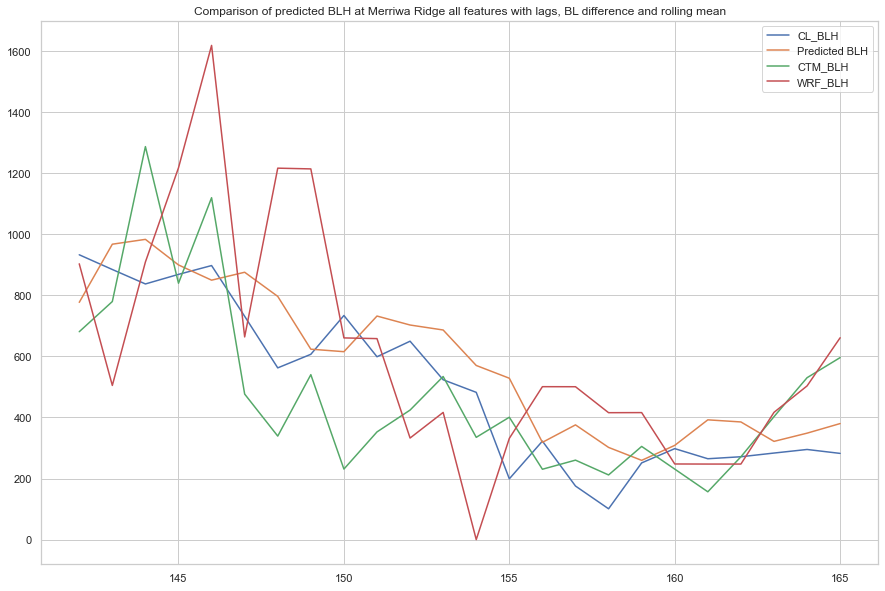

In [92]:
df_ridge_merriwa_ld, ridge_merriwa_ld = ridge_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_ridge_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa Ridge all features with lags, BL difference and rolling mean')

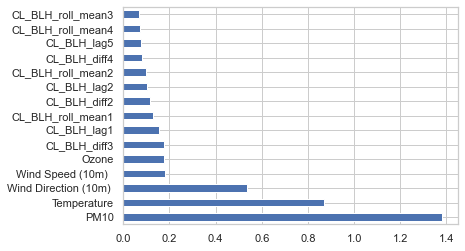

In [93]:
ridge_feature_importance_plot(ridge_merriwa_ld, feature_list_all_ldm)

In [94]:
from sklearn.linear_model import Ridge

#Random search CV
def ridge_modellerL(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    ridge = Ridge(alpha=1, copy_X=False, max_iter=1200, tol=1e-06)
    ridge.fit(X_train, y_train)
    
    #Predict
    
    ridge_predict = ridge.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  ridge_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, ridge

At Lidcombe Ridge all features with lags, BL difference and rolling mean
Index of agreement:0.74312
Root mean squared error:235.45091
Mean absoluate error:188.01339
Mean bias error:-27.25630
DTW distance:2402.75
MASE:0.85481
Pearson correlation:0.549


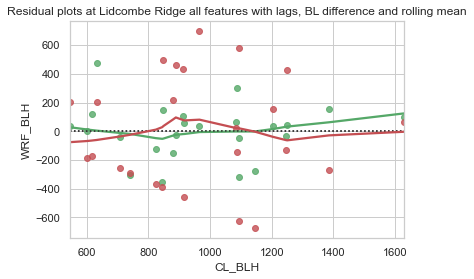

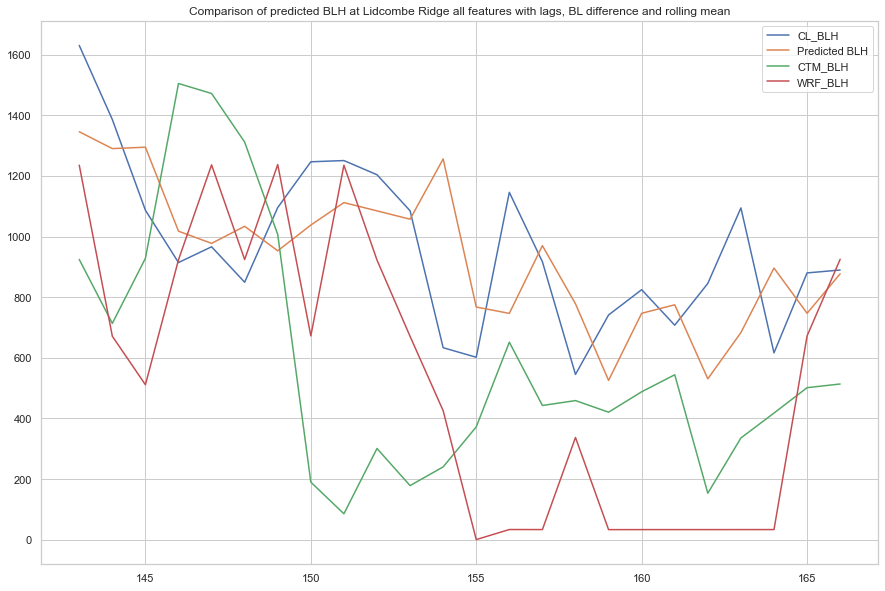

In [95]:
df_ridge_lidcombe_ld, ridge_lidcombe_ld = ridge_modellerL(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_ridge_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe Ridge all features with lags, BL difference and rolling mean')

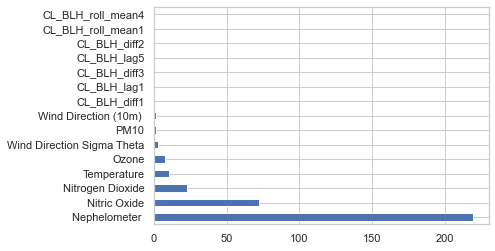

In [96]:
ridge_feature_importance_plot(ridge_lidcombe_ld, feature_list_all_ldm)

### 3.7.2 Grid search CV

In [97]:
from sklearn.linear_model import Ridge

#Grid search CV
def ridge_modeller1(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    ridge = Ridge(alpha=1, copy_X=False, max_iter=1400, solver='saga')
    ridge.fit(X_train, y_train)
    
    #Predict
    
    ridge_predict = ridge.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  ridge_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, ridge

At Merriwa Ridge all features with lags, BL difference and rolling mean
Index of agreement:0.92303
Root mean squared error:135.23037
Mean absoluate error:109.41142
Mean bias error:78.40147
DTW distance:1536.00
MASE:0.57882
Pearson correlation:0.907


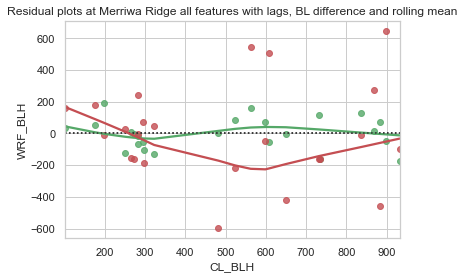

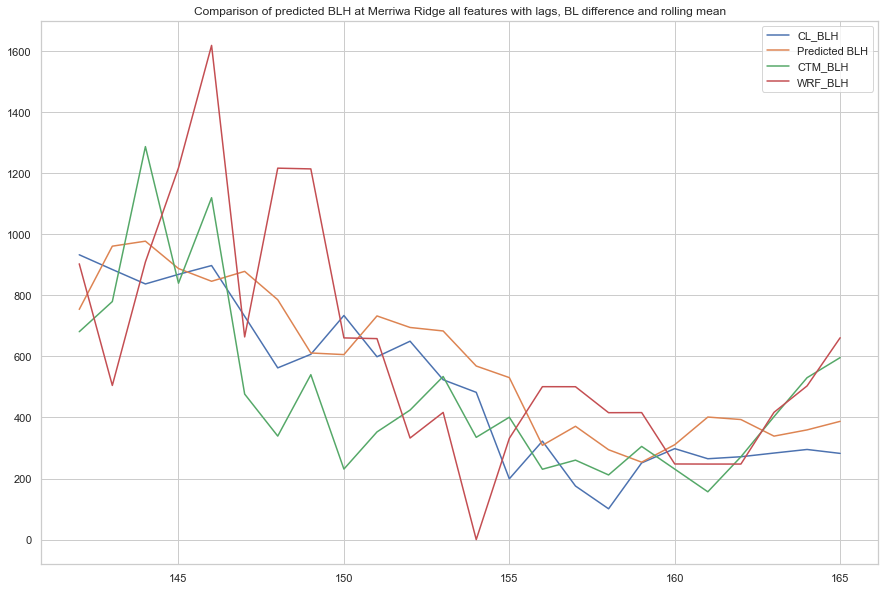

In [98]:
df_ridge_merriwa_ld1, ridge_merriwa_ld1 = ridge_modeller1(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_ridge_merriwa_ld1, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa Ridge all features with lags, BL difference and rolling mean')

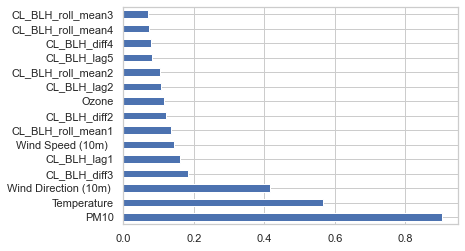

In [99]:
ridge_feature_importance_plot(ridge_merriwa_ld1, feature_list_all_ldm)

In [100]:
from sklearn.linear_model import Ridge

#Grid search CV
def ridge_modeller1L(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    ridge = Ridge(alpha=1, max_iter=1000, solver='saga')
    ridge.fit(X_train, y_train)
    
    #Predict
    
    ridge_predict = ridge.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  ridge_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, ridge

At Lidcombe Ridge all features with lags, BL difference and rolling mean
Index of agreement:0.80361
Root mean squared error:209.26642
Mean absoluate error:169.66216
Mean bias error:-27.90817
DTW distance:1632.64
MASE:0.77138
Pearson correlation:0.652


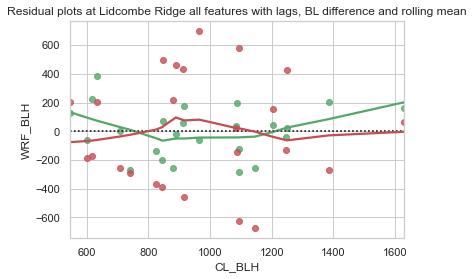

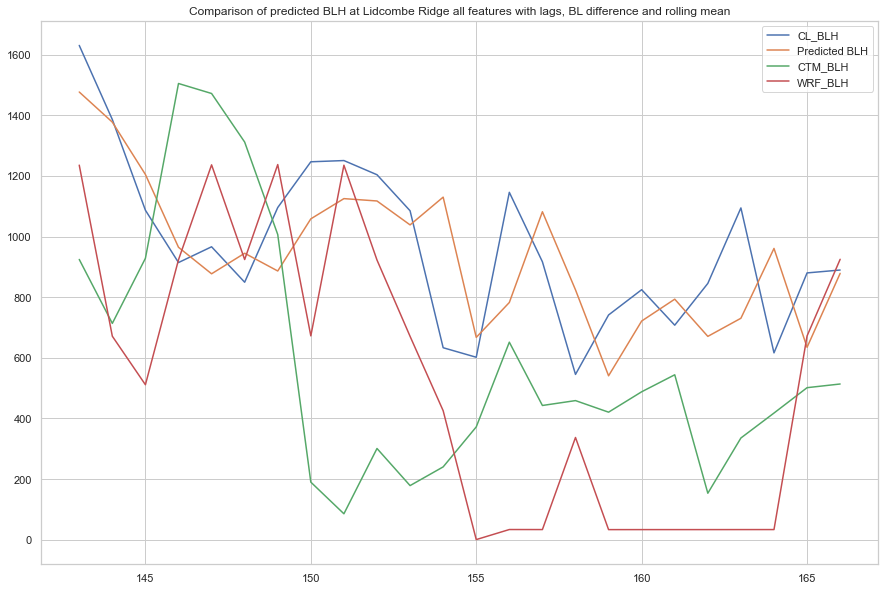

In [101]:
df_ridge_lidcombe_ld1, ridge_lidcombe_ld1 = ridge_modeller1L(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_ridge_lidcombe_ld1, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe Ridge all features with lags, BL difference and rolling mean')

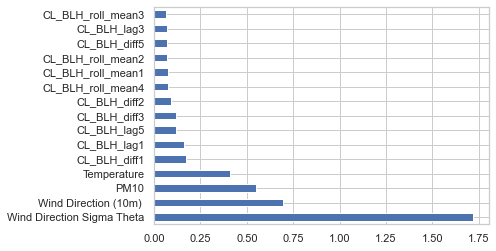

In [102]:
ridge_feature_importance_plot(ridge_lidcombe_ld1, feature_list_all_ldm)

## 3.8 Elastic Net

### 3.8.1 Random search CV

In [103]:
from sklearn.linear_model import ElasticNet

#Random search CV
def enet_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    enet = ElasticNet(alpha=2, l1_ratio=1, max_iter=1800, selection='random', tol=1e-05)
    enet.fit(X_train, y_train)
    
    #Predict
    
    enet_predict = enet.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  enet_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, enet

In [104]:
#Finding the important features for ElasticNet regression
def enet_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533592.7258547535, tolerance: 324.14653704070145
  positive)


At Merriwa ElasticNet all features with lags, BL difference and rolling mean
Index of agreement:0.83569
Root mean squared error:192.39662
Mean absoluate error:166.50393
Mean bias error:152.46844
DTW distance:2539.54
MASE:0.88086
Pearson correlation:0.910


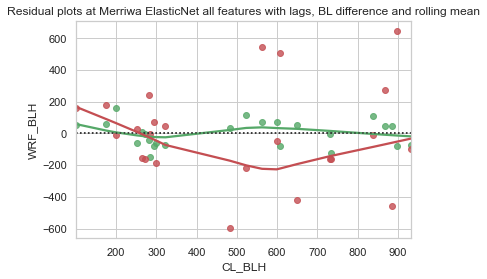

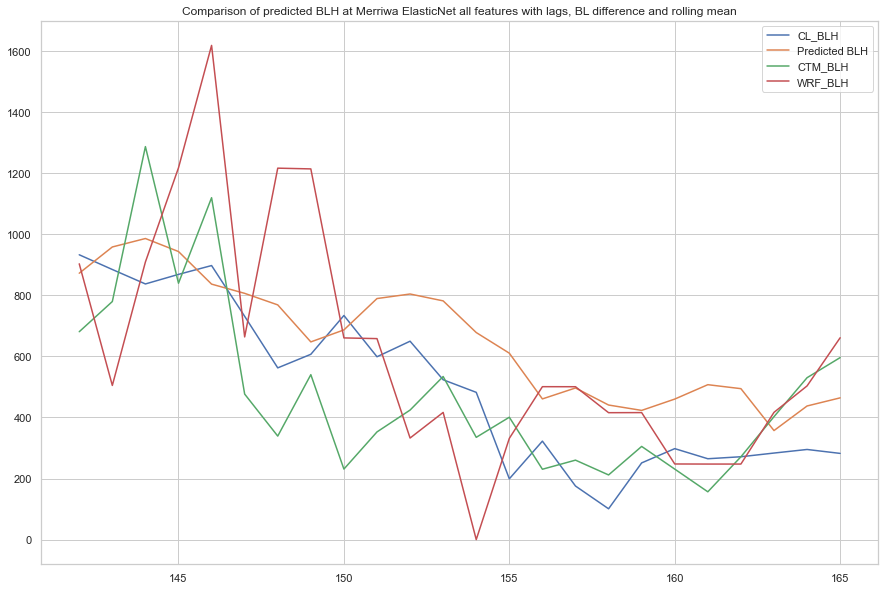

In [105]:
df_enet_merriwa_ld, enet_merriwa_ld = enet_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_enet_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa ElasticNet all features with lags, BL difference and rolling mean')

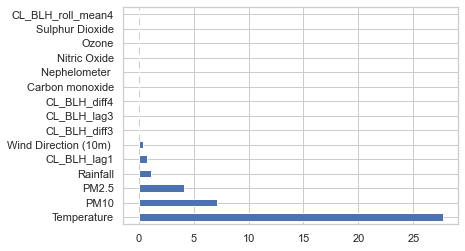

In [106]:
enet_feature_importance_plot(enet_merriwa_ld, feature_list_all_ldm)

In [107]:
from sklearn.linear_model import ElasticNet

#Random search CV
def enet_modellerL(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    enet = ElasticNet(alpha=1, copy_X=False, l1_ratio=1, selection='random', tol=0.001)
    enet.fit(X_train, y_train)
    
    #Predict
    
    enet_predict = enet.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  enet_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, enet

At Lidcombe ElasticNet all features with lags, BL difference and rolling mean
Index of agreement:0.72395
Root mean squared error:240.73034
Mean absoluate error:191.80858
Mean bias error:-23.47896
DTW distance:2600.02
MASE:0.87207
Pearson correlation:0.518


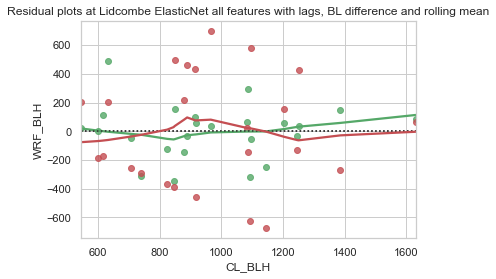

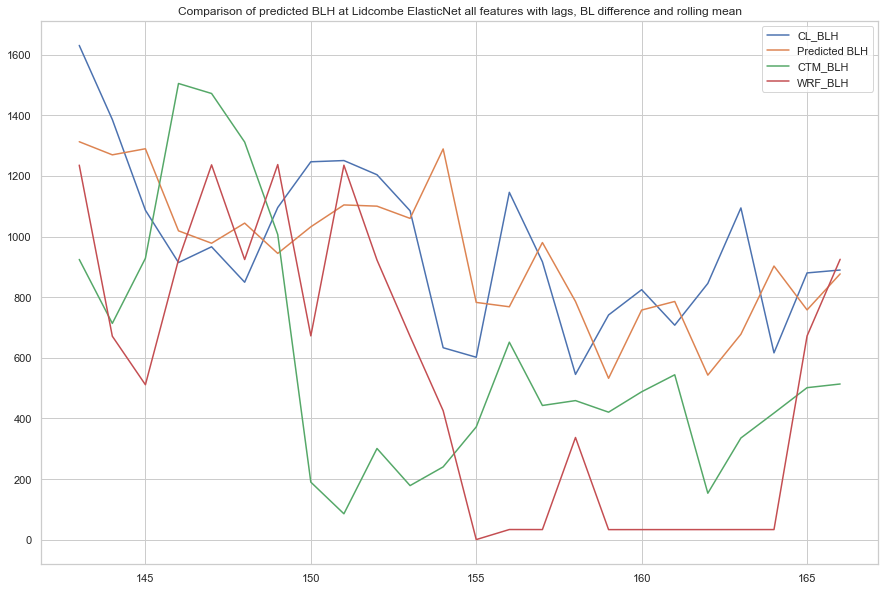

In [108]:
df_enet_lidcombe_ld, enet_lidcombe_ld = enet_modellerL(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_enet_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe ElasticNet all features with lags, BL difference and rolling mean')

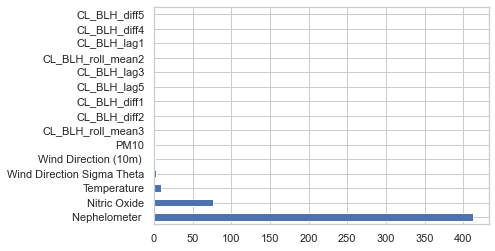

In [109]:
enet_feature_importance_plot(enet_lidcombe_ld, feature_list_all_ldm)

### 3.8.2 Grid search CV

In [110]:
from sklearn.linear_model import ElasticNet

#Grid search CV
def enet_modeller1(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    enet = ElasticNet(alpha=2, copy_X=False, l1_ratio=1, max_iter=1200, selection='random', tol=0.001)
    enet.fit(X_train, y_train)
    
    #Predict
    
    enet_predict = enet.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  enet_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, enet

At Merriwa ElasticNet all features with lags, BL difference and rolling mean
Index of agreement:0.83565
Root mean squared error:192.41763
Mean absoluate error:166.52314
Mean bias error:152.49108
DTW distance:2539.99
MASE:0.88097
Pearson correlation:0.910


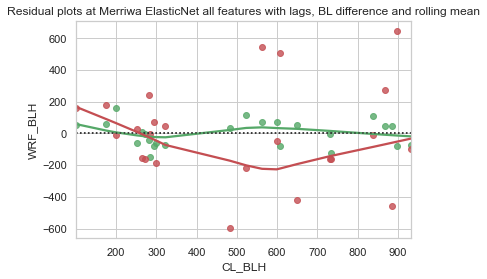

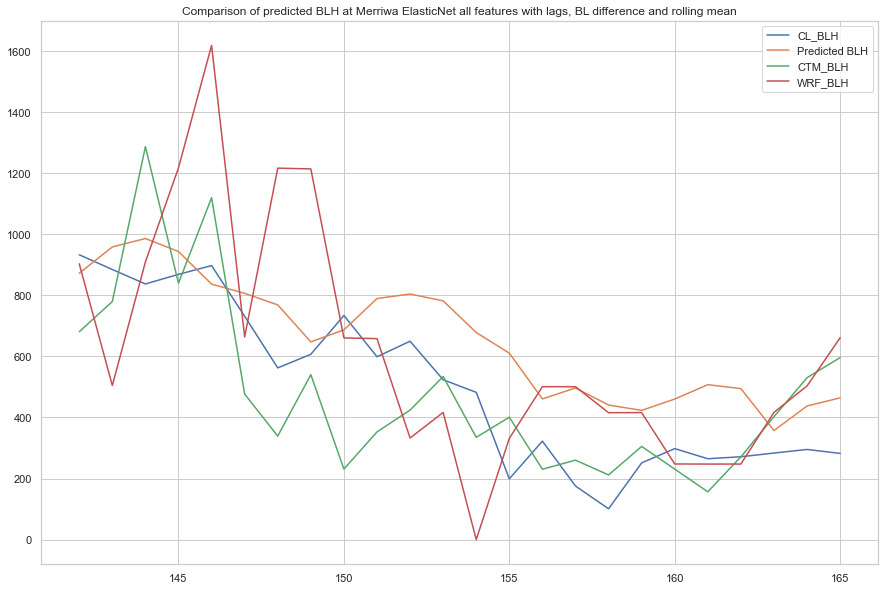

In [111]:
df_enet_merriwa_ld1, enet_merriwa_ld1 = enet_modeller1(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_enet_merriwa_ld1, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa ElasticNet all features with lags, BL difference and rolling mean')

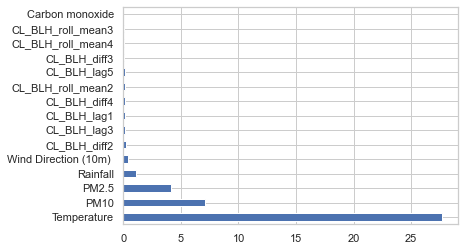

In [112]:
enet_feature_importance_plot(enet_merriwa_ld1, feature_list_all_ldm)

In [113]:
from sklearn.linear_model import ElasticNet

#Grid search CV
def enet_modeller1L(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    enet = ElasticNet(alpha=5, copy_X=False, l1_ratio=1, max_iter=1200, normalize=True, selection='random', tol=0.001)
    enet.fit(X_train, y_train)
    
    #Predict
    
    enet_predict = enet.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  enet_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, enet

At Lidcombe ElasticNet all features with lags, BL difference and rolling mean
Index of agreement:0.79665
Root mean squared error:194.95918
Mean absoluate error:161.87651
Mean bias error:-1.86582
DTW distance:2617.02
MASE:0.73598
Pearson correlation:0.672


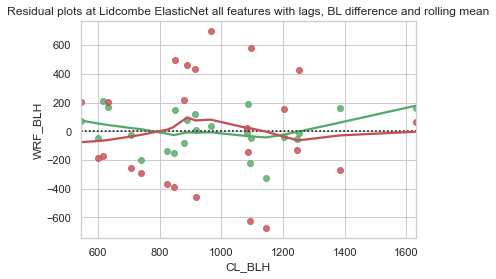

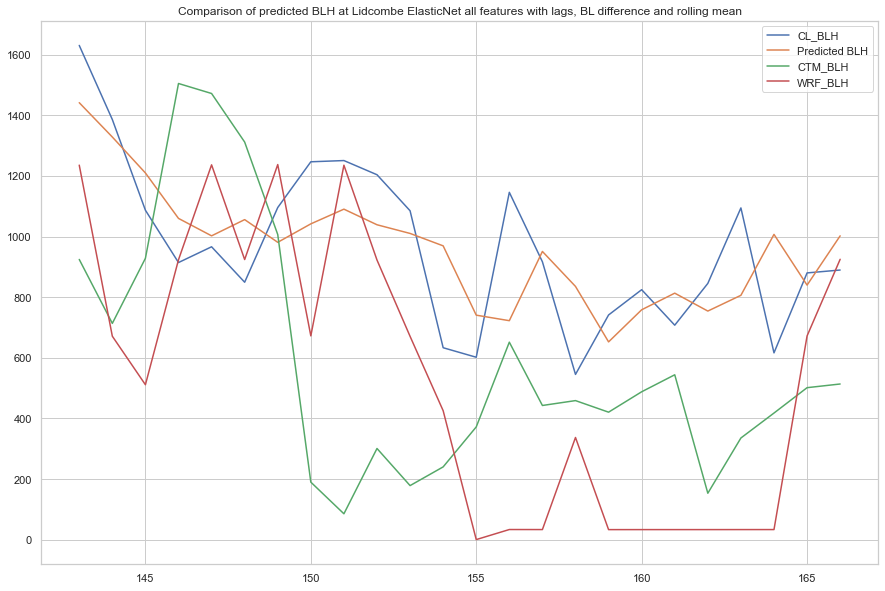

In [114]:
df_enet_lidcombe_ld1, enet_lidcombe_ld1 = enet_modeller1L(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_enet_lidcombe_ld1, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe ElasticNet all features with lags, BL difference and rolling mean')

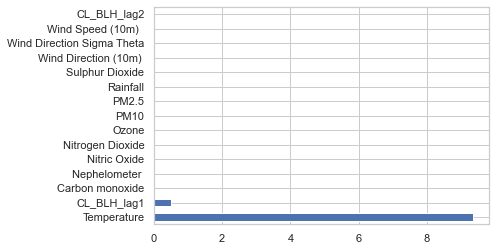

In [115]:
enet_feature_importance_plot(enet_lidcombe_ld1, feature_list_all_ldm)

# 4.) Results summary

## 4.1 Plot combinations

In [116]:
def combine_data_plots(df_filled, results_df, col_names_df):
    time_stamp_index = df_filled.tail(24)['datetime']

    df_combined = pd.DataFrame(df_filled.tail(24)['CL_BLH'])

    for i in range(0, len(results_df)):
        df_combined[col_names_df[i]] = results_df[i]

    df_combined = df_combined.set_index(time_stamp_index)
    
    return df_combined

In [117]:
def combined_predicted_plots(df, title):
    ax = df.plot(figsize = (15,10), title = title)
    #CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[1].set_linewidth(3)
    #WRF BLH
    ax.lines[2].set_linestyle('dashed')
    ax.lines[2].set_linewidth(3)

    ax.lines[3].set_color('red')
    ax.lines[3].set_linewidth(2)
    
    ax.lines[4].set_color('blue')
    ax.lines[4].set_linewidth(2)
    
    ax.lines[5].set_color('grey')
    ax.lines[5].set_linewidth(2)
    
    ax.lines[6].set_color('magenta')
    ax.lines[6].set_linewidth(2)
    
    ax.lines[7].set_color('purple')
    ax.lines[7].set_linewidth(2)
    
    ax.lines[8].set_color('brown')
    ax.lines[8].set_linewidth(2)
    
    ax.lines[9].set_color('black')
    ax.lines[9].set_linewidth(2)
    
    #Reset legend
    ax.legend()
   # ax.grid()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

In [118]:
results_df_merriwa_random = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], df_rf_merriwa_ld['Predicted BLH'],
                            df_vreg_merriwa_ld['Predicted BLH'], df_mulin_merriwa_ld['Predicted BLH'],
                            df_dtree_merriwa_ld['Predicted BLH'], df_lasso_merriwa_ld['Predicted BLH'],
                            df_ridge_merriwa_ld['Predicted BLH'], df_enet_merriwa_ld['Predicted BLH']]

results_df_merriwa_grid = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], df_rf_merriwa_ld1['Predicted BLH'],
                            df_vreg_merriwa_ld1['Predicted BLH'], df_mulin_merriwa_ld['Predicted BLH'],
                            df_dtree_merriwa_ld1['Predicted BLH'], df_lasso_merriwa_ld1['Predicted BLH'],
                            df_ridge_merriwa_ld1['Predicted BLH'], df_enet_merriwa_ld1['Predicted BLH']]

results_df_lidcombe_random = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], df_rf_lidcombe_ld['Predicted BLH'],
                            df_vreg_lidcombe_ld['Predicted BLH'], df_mulin_lidcombe_ld['Predicted BLH'],
                            df_dtree_lidcombe_ld['Predicted BLH'], df_lasso_lidcombe_ld['Predicted BLH'],
                            df_ridge_lidcombe_ld['Predicted BLH'], df_enet_lidcombe_ld['Predicted BLH']]

results_df_lidcombe_grid = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], df_rf_lidcombe_ld1['Predicted BLH'],
                            df_vreg_lidcombe_ld1['Predicted BLH'], df_mulin_lidcombe_ld['Predicted BLH'],
                            df_dtree_lidcombe_ld1['Predicted BLH'], df_lasso_lidcombe_ld1['Predicted BLH'],
                            df_ridge_lidcombe_ld1['Predicted BLH'], df_enet_lidcombe_ld1['Predicted BLH']]


col_names = ['CTM BLH', 'WRF BLH', 'Random Forest', 'SVR',
             'Multiple Linear Regression', 'Decision Tree',
            'Lasso', 'Ridge', 'ElasticNet']

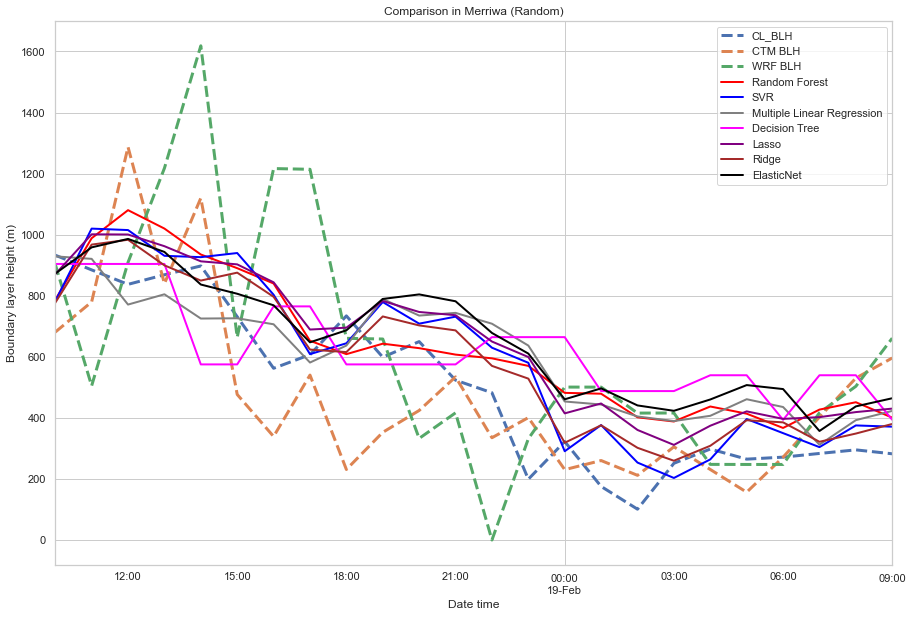

In [119]:
df_combined_predicted_merriwa_random = combine_data_plots(df_merriwa_filled, results_df_merriwa_random, col_names)
combined_predicted_plots(df_combined_predicted_merriwa_random, 'Comparison in Merriwa (Random)')

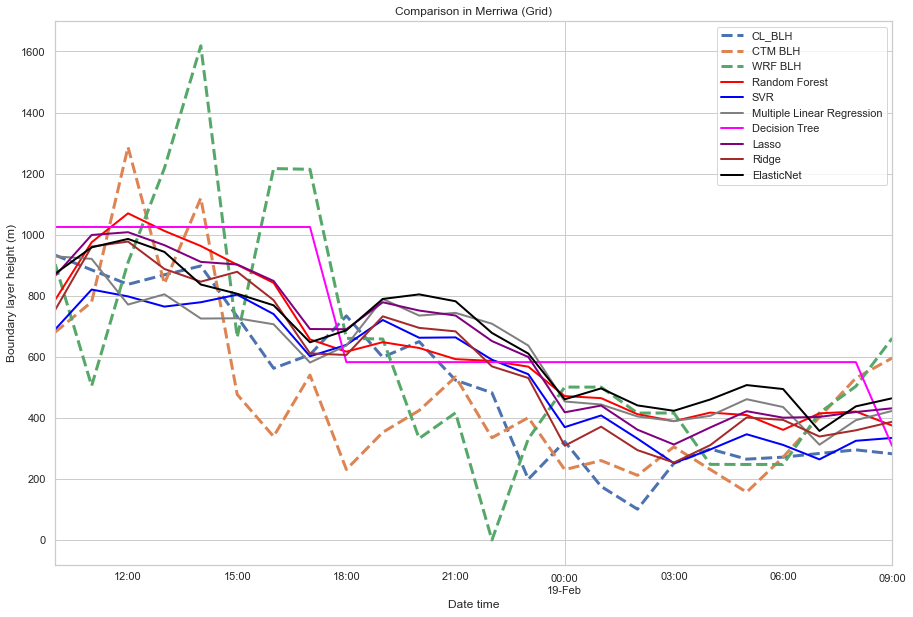

In [120]:
df_combined_predicted_merriwa_grid = combine_data_plots(df_merriwa_filled, results_df_merriwa_grid, col_names)
combined_predicted_plots(df_combined_predicted_merriwa_grid, 'Comparison in Merriwa (Grid)')

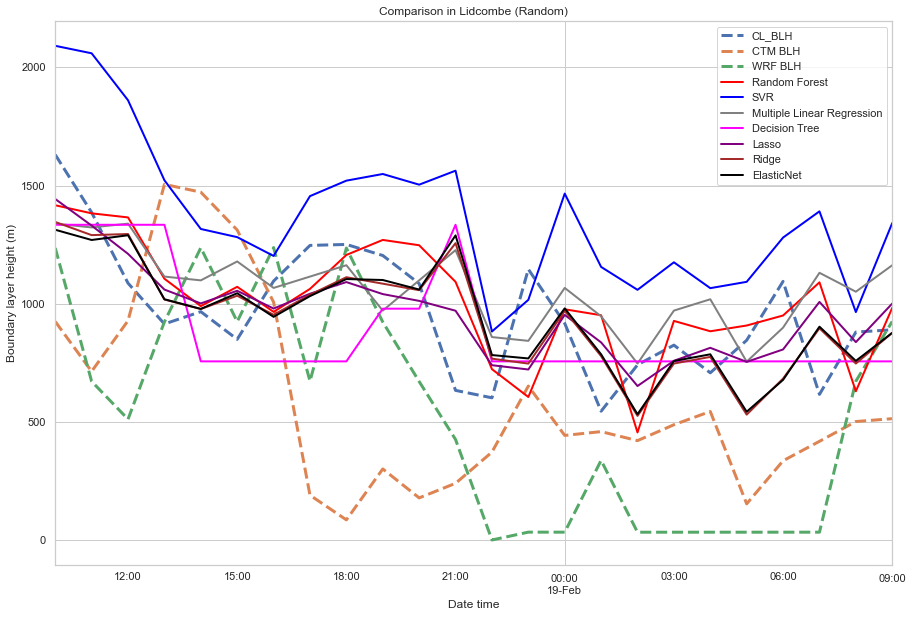

In [121]:
df_combined_predicted_lidcombe_random = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_random, col_names)
combined_predicted_plots(df_combined_predicted_lidcombe_random, 'Comparison in Lidcombe (Random)')

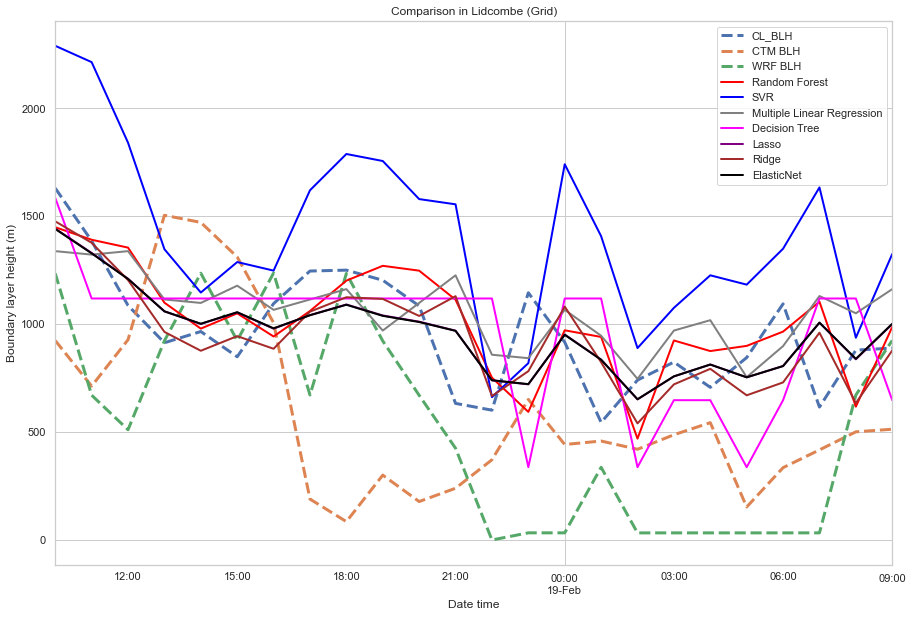

In [122]:
df_combined_predicted_lidcombe_grid = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_grid, col_names)
combined_predicted_plots(df_combined_predicted_lidcombe_grid, 'Comparison in Lidcombe (Grid)')

## 4.2 Final report

In [123]:
def predicted_plots_combined(df, title):
    ax = df.plot(figsize = (15,10), title = title)
    #CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[1].set_linewidth(3)
    #WRF BLH
    ax.lines[2].set_linestyle('dashed')
    ax.lines[2].set_linewidth(3)
    
    ax.lines[3].set_linewidth(2)
     
    #Reset legend
    ax.legend()
#     ax.grid()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')
    #plt.ylim(0,1800)

### 4.2.1 Merriwa Plots

In [124]:
results_df_merriwa_rf_random = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
                                    df_rf_merriwa_ld['Predicted BLH']]

results_df_merriwa_vreg_random = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 
                                    df_vreg_merriwa_ld['Predicted BLH']]

results_df_merriwa_mulin = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 
                                   df_mulin_merriwa_ld['Predicted BLH']]

results_df_merriwa_dtree_random = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
                                    df_dtree_merriwa_ld['Predicted BLH']]

results_df_merriwa_lasso_random = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 
                                    df_lasso_merriwa_ld['Predicted BLH']]

results_df_merriwa_ridge_random = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 
                                   df_ridge_merriwa_ld['Predicted BLH']]

results_df_merriwa_enet_random = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
                                    df_enet_merriwa_ld['Predicted BLH']]



col_names_df_rf_random = ['CTM BLH', 'WRF BLH', 'Random Forest model prediction']
col_names_df_vreg_random = ['CTM BLH', 'WRF BLH', 'SVR model prediction']
col_names_df_mulin = ['CTM BLH', 'WRF BLH', 'Multiple linear regression model prediction']
col_names_df_dtree_random = ['CTM BLH', 'WRF BLH', 'Decision Tree model prediction']
col_names_df_lasso_random = ['CTM BLH', 'WRF BLH', 'Lasso regression model prediction']
col_names_df_ridge_random = ['CTM BLH', 'WRF BLH', 'Ridge regression model prediction']
col_names_df_enet_random = ['CTM BLH', 'WRF BLH', 'Elasticnet regression model prediction']

df_combined_predicted_merriwa_rf_random = combine_data_plots(df_merriwa_filled, results_df_merriwa_rf_random, col_names_df_rf_random)
df_combined_predicted_merriwa_vreg_random = combine_data_plots(df_merriwa_filled, results_df_merriwa_vreg_random, col_names_df_vreg_random)
df_combined_predicted_merriwa_mulin= combine_data_plots(df_merriwa_filled, results_df_merriwa_mulin, col_names_df_mulin)
df_combined_predicted_merriwa_dtree_random = combine_data_plots(df_merriwa_filled, results_df_merriwa_dtree_random, col_names_df_dtree_random)
df_combined_predicted_merriwa_lasso_random = combine_data_plots(df_merriwa_filled, results_df_merriwa_lasso_random, col_names_df_lasso_random)
df_combined_predicted_merriwa_ridge_random = combine_data_plots(df_merriwa_filled, results_df_merriwa_ridge_random, col_names_df_ridge_random)
df_combined_predicted_merriwa_enet_random = combine_data_plots(df_merriwa_filled, results_df_merriwa_enet_random, col_names_df_enet_random)

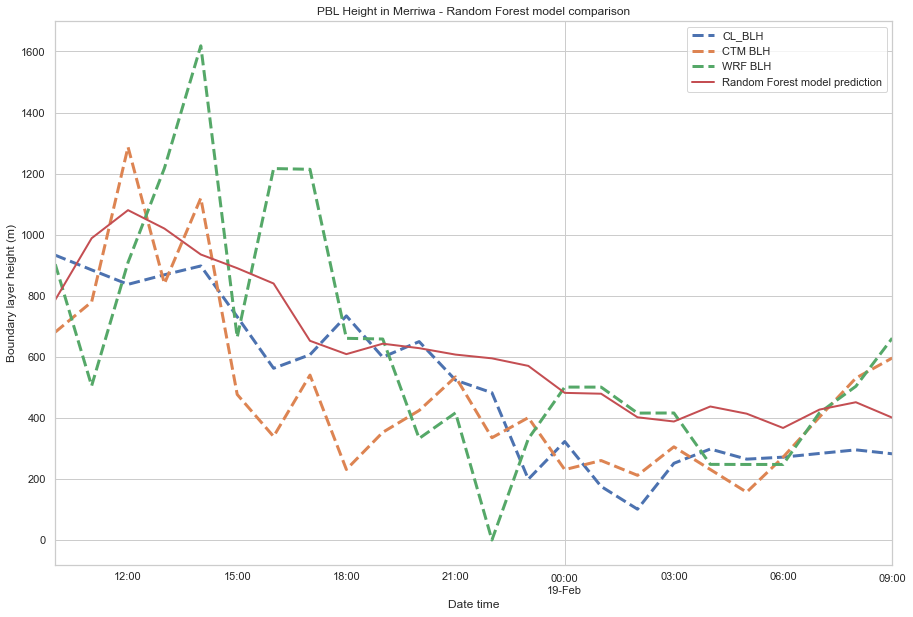

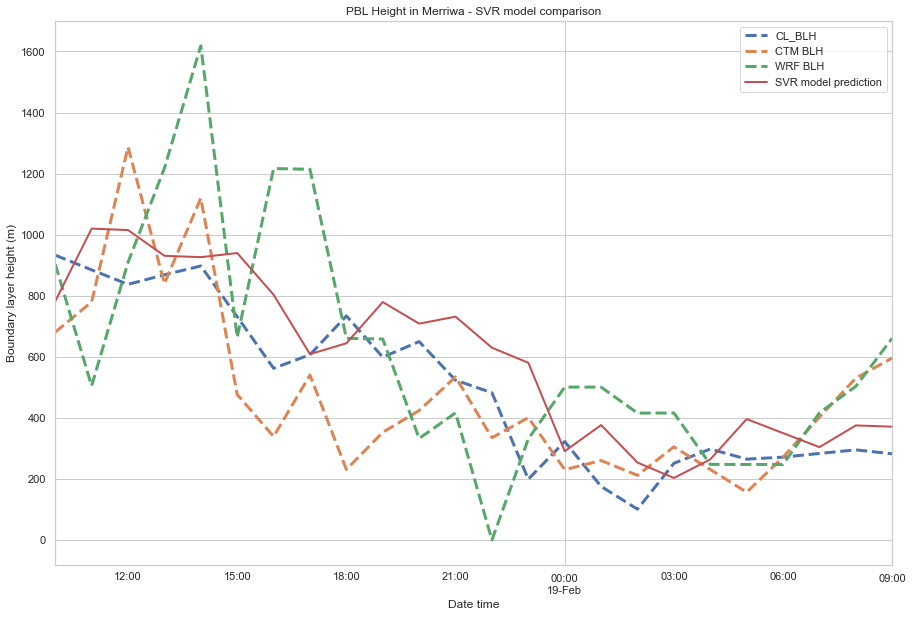

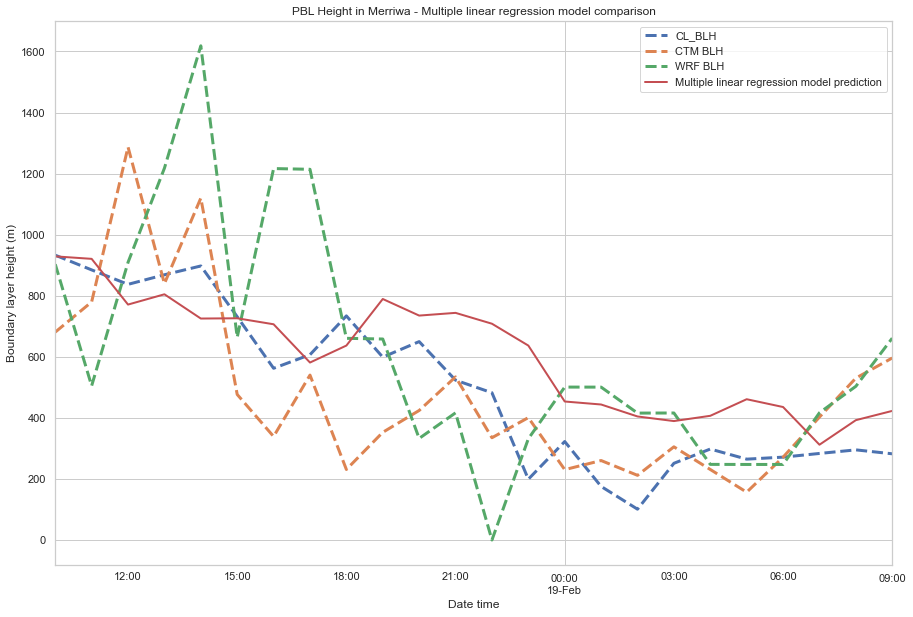

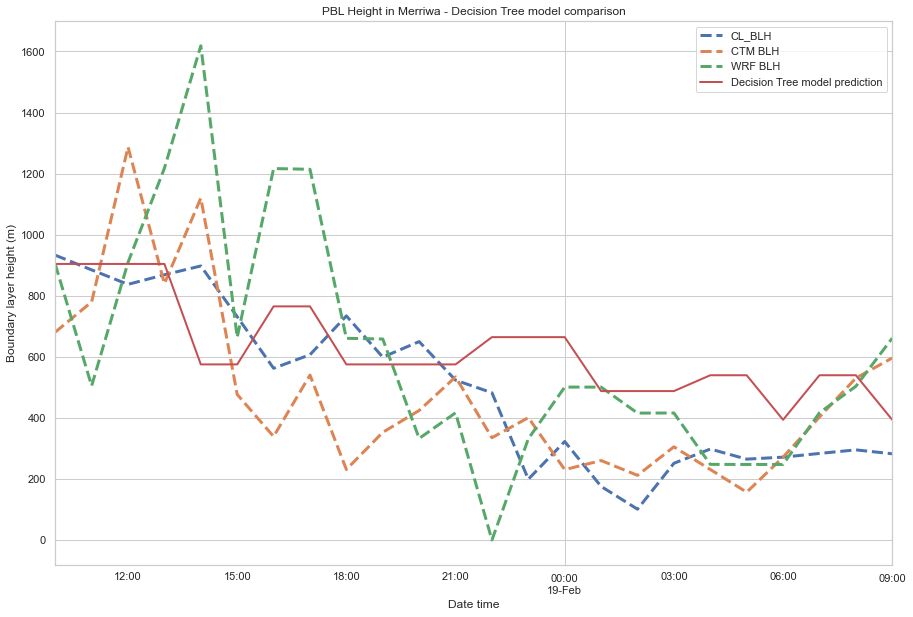

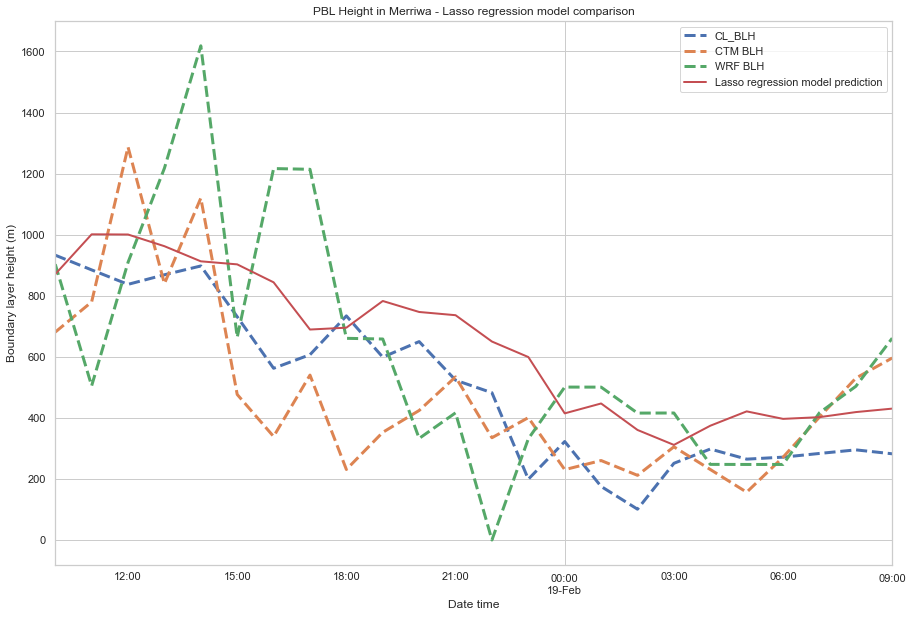

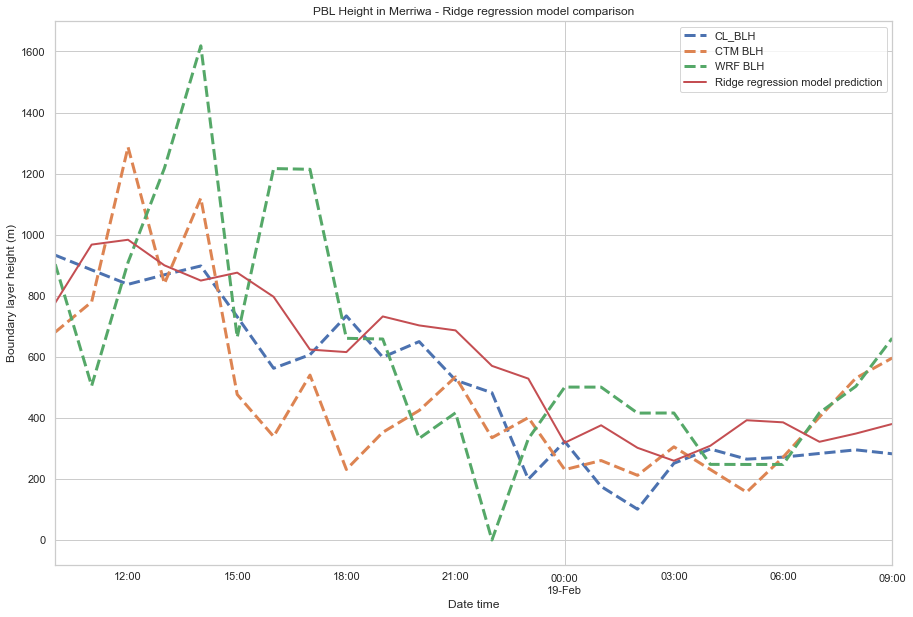

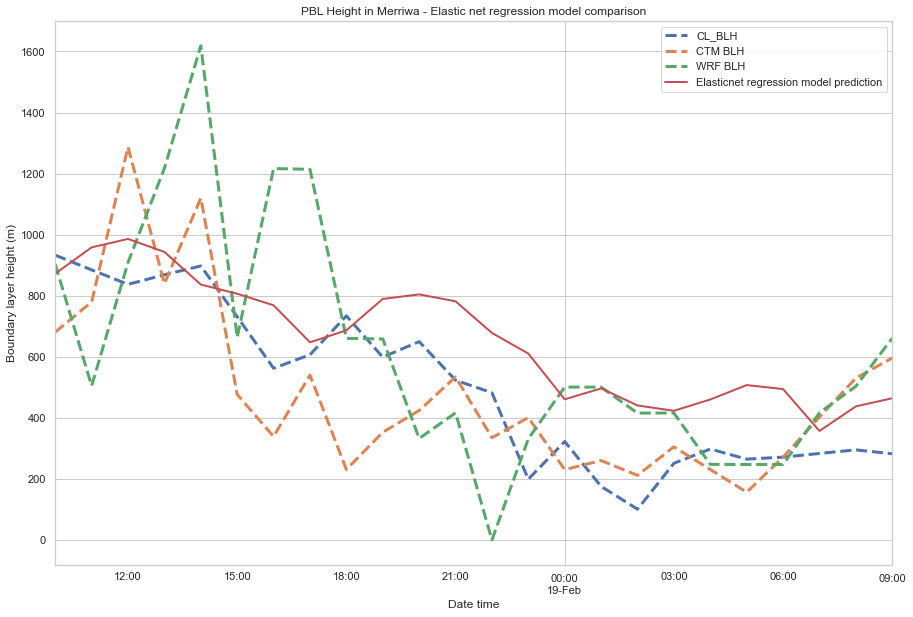

In [125]:
predicted_plots_combined(df_combined_predicted_merriwa_rf_random,'PBL Height in Merriwa - Random Forest model comparison')
predicted_plots_combined(df_combined_predicted_merriwa_vreg_random,'PBL Height in Merriwa - SVR model comparison')
predicted_plots_combined(df_combined_predicted_merriwa_mulin,'PBL Height in Merriwa - Multiple linear regression model comparison')
predicted_plots_combined(df_combined_predicted_merriwa_dtree_random,'PBL Height in Merriwa - Decision Tree model comparison')
predicted_plots_combined(df_combined_predicted_merriwa_lasso_random,'PBL Height in Merriwa - Lasso regression model comparison')
predicted_plots_combined(df_combined_predicted_merriwa_ridge_random,'PBL Height in Merriwa - Ridge regression model comparison')
predicted_plots_combined(df_combined_predicted_merriwa_enet_random,'PBL Height in Merriwa - Elastic net regression model comparison')

In [126]:
results_df_merriwa_rf_grid = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
                                    df_rf_merriwa_ld1['Predicted BLH']]

results_df_merriwa_vreg_grid = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 
                                    df_vreg_merriwa_ld1['Predicted BLH']]

results_df_merriwa_mulin = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 
                                   df_mulin_merriwa_ld['Predicted BLH']]

results_df_merriwa_dtree_grid = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
                                    df_dtree_merriwa_ld1['Predicted BLH']]

results_df_merriwa_lasso_grid = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 
                                    df_lasso_merriwa_ld1['Predicted BLH']]

results_df_merriwa_ridge_grid = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 
                                   df_ridge_merriwa_ld1['Predicted BLH']]

results_df_merriwa_enet_grid = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
                                    df_enet_merriwa_ld1['Predicted BLH']]



col_names_df_rf_grid = ['CTM BLH', 'WRF BLH', 'Random Forest(Grid) model prediction']
col_names_df_vreg_grid = ['CTM BLH', 'WRF BLH', 'SVR(Grid) model prediction']
col_names_df_mulin = ['CTM BLH', 'WRF BLH', 'Multiple linear regression(Grid) model prediction']
col_names_df_dtree_grid = ['CTM BLH', 'WRF BLH', 'Decision Tree(Grid) model prediction']
col_names_df_lasso_grid = ['CTM BLH', 'WRF BLH', 'Lasso regression(Grid) model prediction']
col_names_df_ridge_grid = ['CTM BLH', 'WRF BLH', 'Ridge regression(Grid) model prediction']
col_names_df_enet_grid = ['CTM BLH', 'WRF BLH', 'Elasticnet regression(Grid) model prediction']

df_combined_predicted_merriwa_rf_grid = combine_data_plots(df_merriwa_filled, results_df_merriwa_rf_grid, col_names_df_rf_grid)
df_combined_predicted_merriwa_vreg_grid = combine_data_plots(df_merriwa_filled, results_df_merriwa_vreg_grid, col_names_df_vreg_grid)
df_combined_predicted_merriwa_mulin= combine_data_plots(df_merriwa_filled, results_df_merriwa_mulin, col_names_df_mulin)
df_combined_predicted_merriwa_dtree_grid = combine_data_plots(df_merriwa_filled, results_df_merriwa_dtree_grid, col_names_df_dtree_grid)
df_combined_predicted_merriwa_lasso_grid = combine_data_plots(df_merriwa_filled, results_df_merriwa_lasso_grid, col_names_df_lasso_grid)
df_combined_predicted_merriwa_ridge_grid = combine_data_plots(df_merriwa_filled, results_df_merriwa_ridge_grid, col_names_df_ridge_grid)
df_combined_predicted_merriwa_enet_grid = combine_data_plots(df_merriwa_filled, results_df_merriwa_enet_grid, col_names_df_enet_grid)

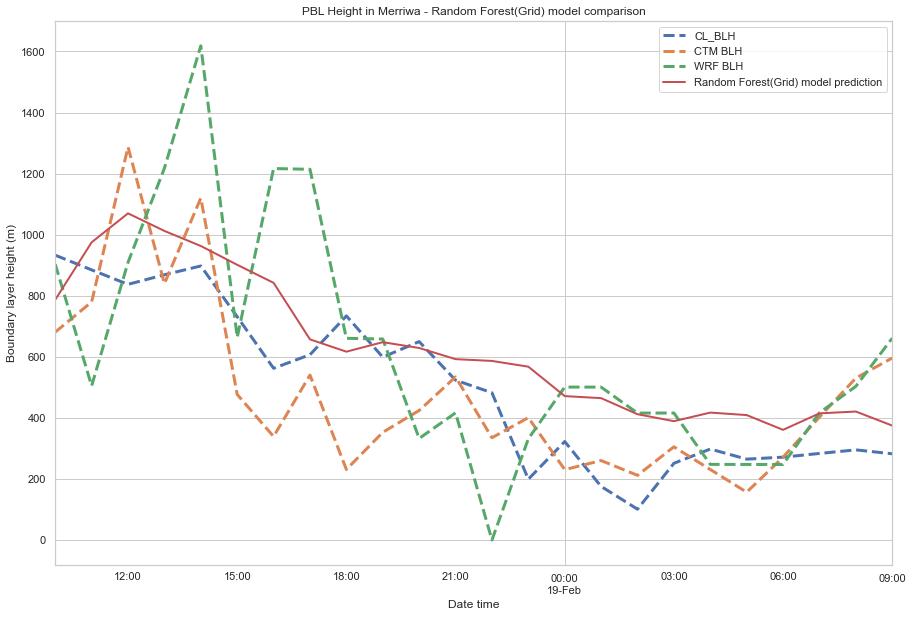

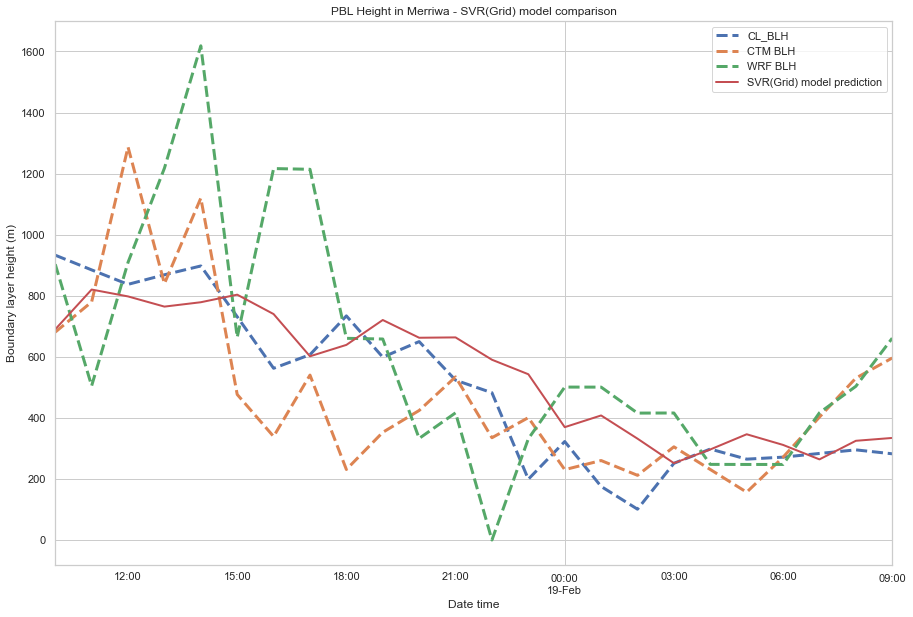

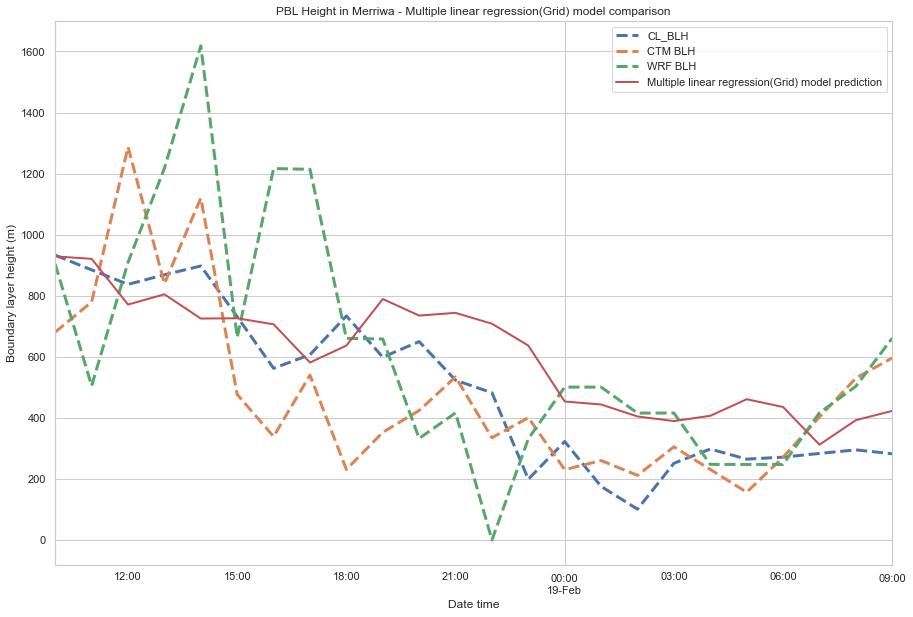

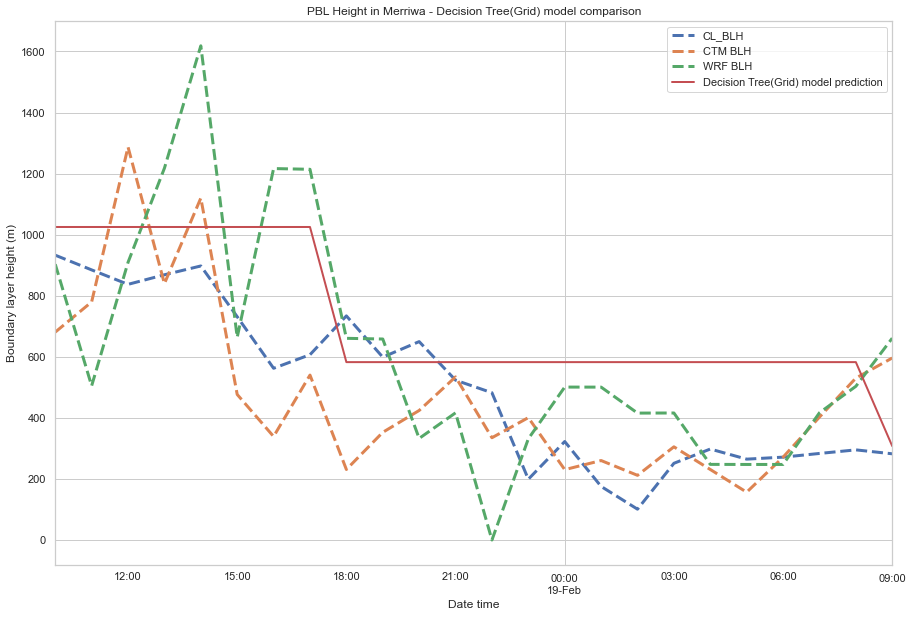

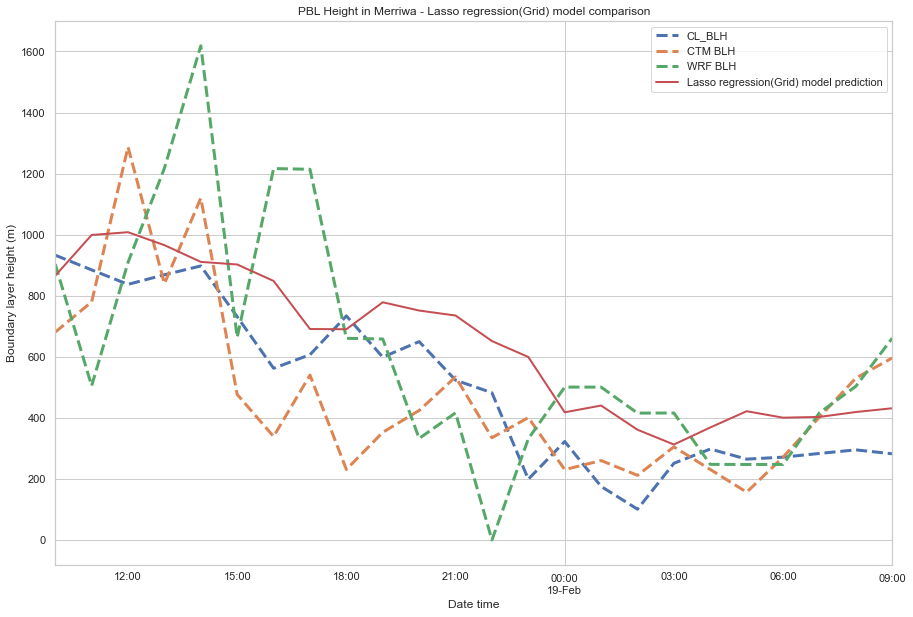

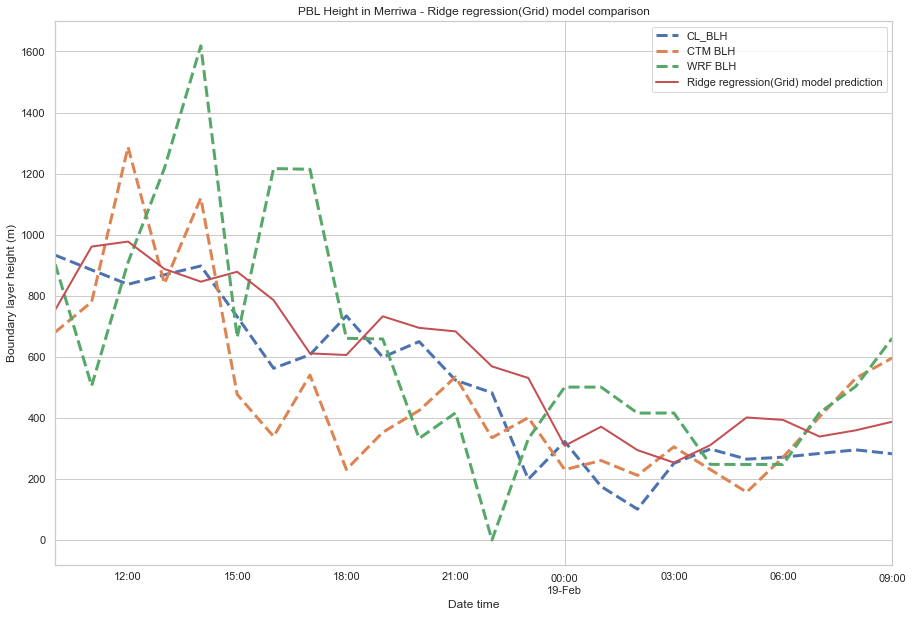

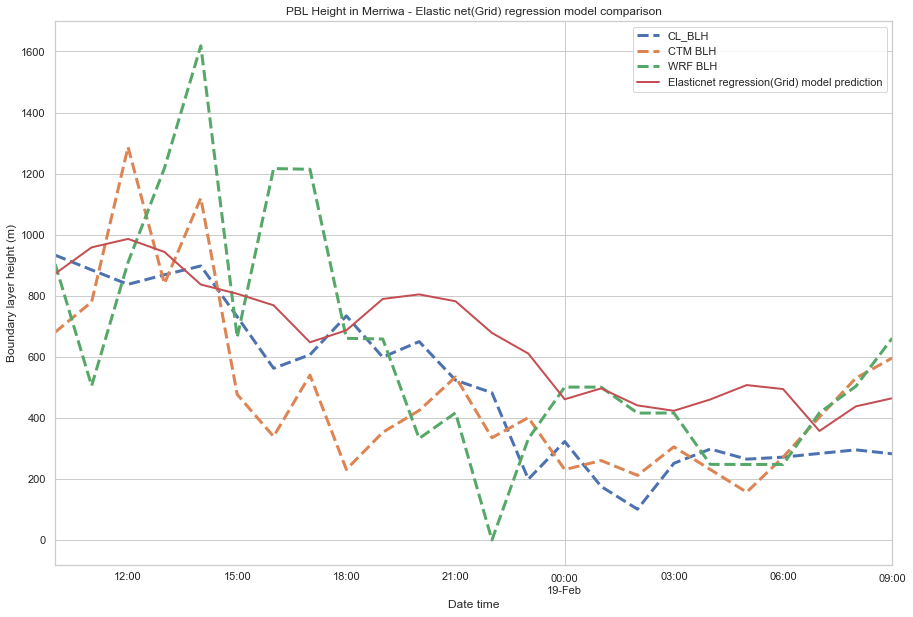

In [127]:
predicted_plots_combined(df_combined_predicted_merriwa_rf_grid,'PBL Height in Merriwa - Random Forest(Grid) model comparison')
predicted_plots_combined(df_combined_predicted_merriwa_vreg_grid,'PBL Height in Merriwa - SVR(Grid) model comparison')
predicted_plots_combined(df_combined_predicted_merriwa_mulin,'PBL Height in Merriwa - Multiple linear regression(Grid) model comparison')
predicted_plots_combined(df_combined_predicted_merriwa_dtree_grid,'PBL Height in Merriwa - Decision Tree(Grid) model comparison')
predicted_plots_combined(df_combined_predicted_merriwa_lasso_grid,'PBL Height in Merriwa - Lasso regression(Grid) model comparison')
predicted_plots_combined(df_combined_predicted_merriwa_ridge_grid,'PBL Height in Merriwa - Ridge regression(Grid) model comparison')
predicted_plots_combined(df_combined_predicted_merriwa_enet_grid,'PBL Height in Merriwa - Elastic net(Grid) regression model comparison')

### 4.2.2 Lidcombe plots

In [128]:
results_df_lidcombe_rf_random = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
                                    df_rf_lidcombe_ld['Predicted BLH']]

results_df_lidcombe_vreg_random = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], 
                                    df_vreg_lidcombe_ld['Predicted BLH']]

results_df_lidcombe_mulin = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], 
                                   df_mulin_lidcombe_ld['Predicted BLH']]

results_df_lidcombe_dtree_random = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
                                    df_dtree_lidcombe_ld['Predicted BLH']]

results_df_lidcombe_lasso_random = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], 
                                    df_lasso_lidcombe_ld['Predicted BLH']]

results_df_lidcombe_ridge_random = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], 
                                   df_ridge_lidcombe_ld['Predicted BLH']]

results_df_lidcombe_enet_random = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
                                    df_enet_lidcombe_ld['Predicted BLH']]



col_names_df_rf_random = ['CTM BLH', 'WRF BLH', 'Random Forest model prediction']
col_names_df_vreg_random = ['CTM BLH', 'WRF BLH', 'SVR model prediction']
col_names_df_mulin = ['CTM BLH', 'WRF BLH', 'Multiple linear regression model prediction']
col_names_df_dtree_random = ['CTM BLH', 'WRF BLH', 'Decision Tree model prediction']
col_names_df_lasso_random = ['CTM BLH', 'WRF BLH', 'Lasso regression model prediction']
col_names_df_ridge_random = ['CTM BLH', 'WRF BLH', 'Ridge regression model prediction']
col_names_df_enet_random = ['CTM BLH', 'WRF BLH', 'Elasticnet regression model prediction']

df_combined_predicted_lidcombe_rf_random = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_rf_random, col_names_df_rf_random)
df_combined_predicted_lidcombe_vreg_random = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_vreg_random, col_names_df_vreg_random)
df_combined_predicted_lidcombe_mulin= combine_data_plots(df_lidcombe_filled, results_df_lidcombe_mulin, col_names_df_mulin)
df_combined_predicted_lidcombe_dtree_random = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_dtree_random, col_names_df_dtree_random)
df_combined_predicted_lidcombe_lasso_random = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_lasso_random, col_names_df_lasso_random)
df_combined_predicted_lidcombe_ridge_random = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_ridge_random, col_names_df_ridge_random)
df_combined_predicted_lidcombe_enet_random = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_enet_random, col_names_df_enet_random)

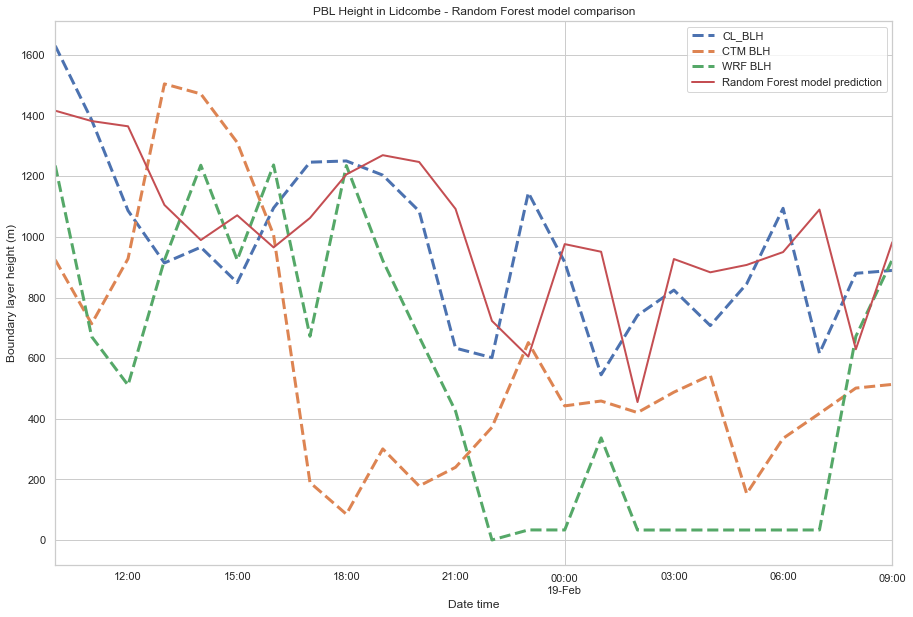

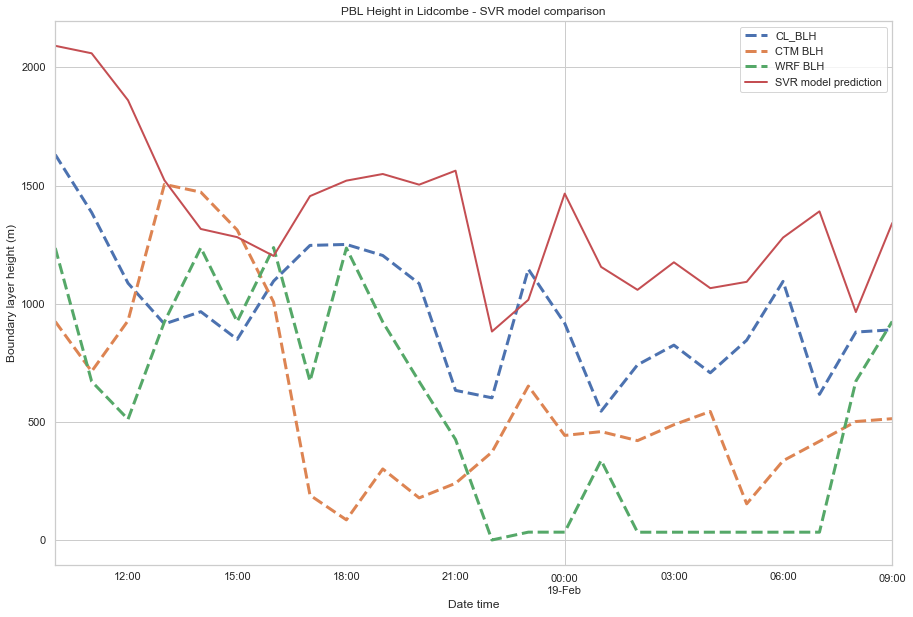

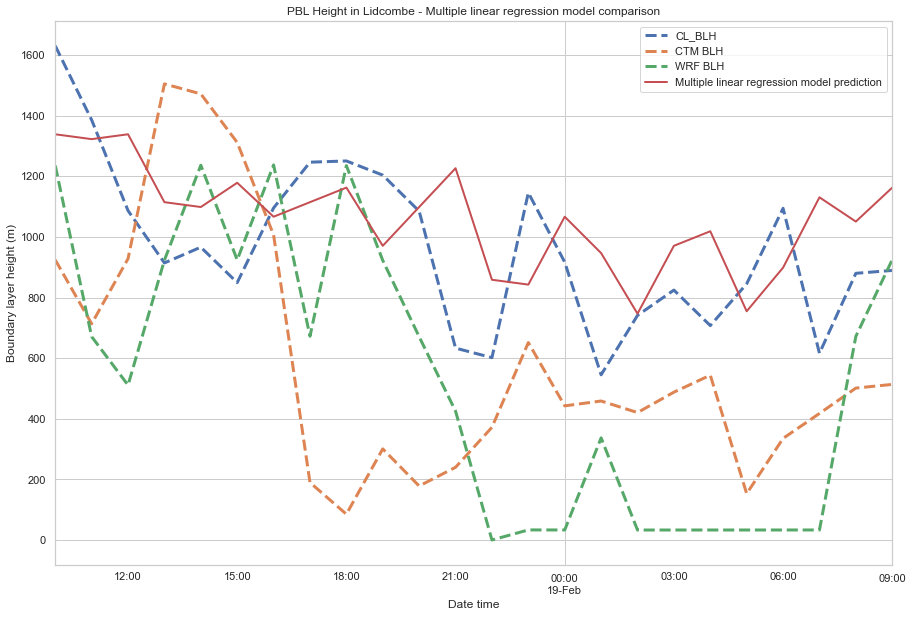

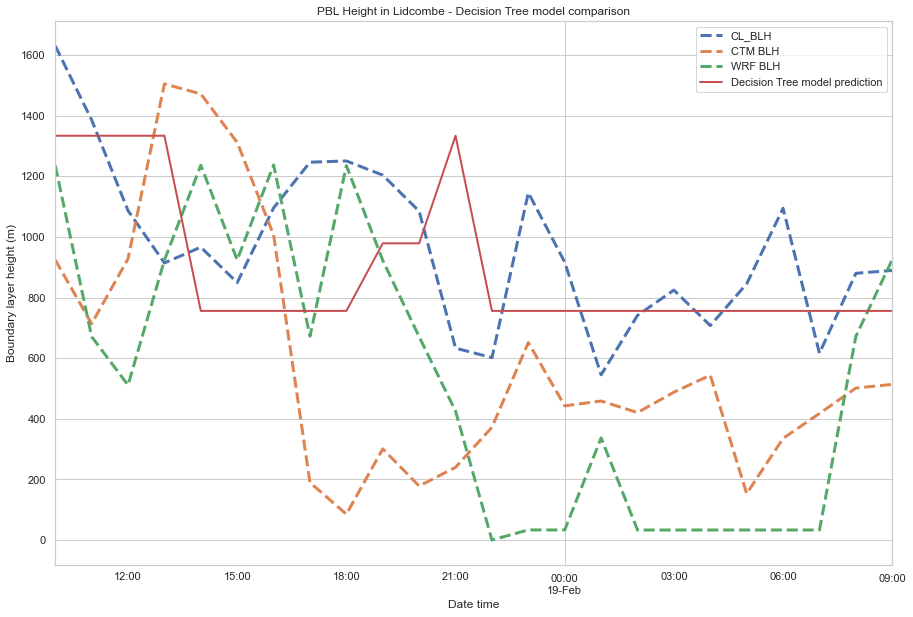

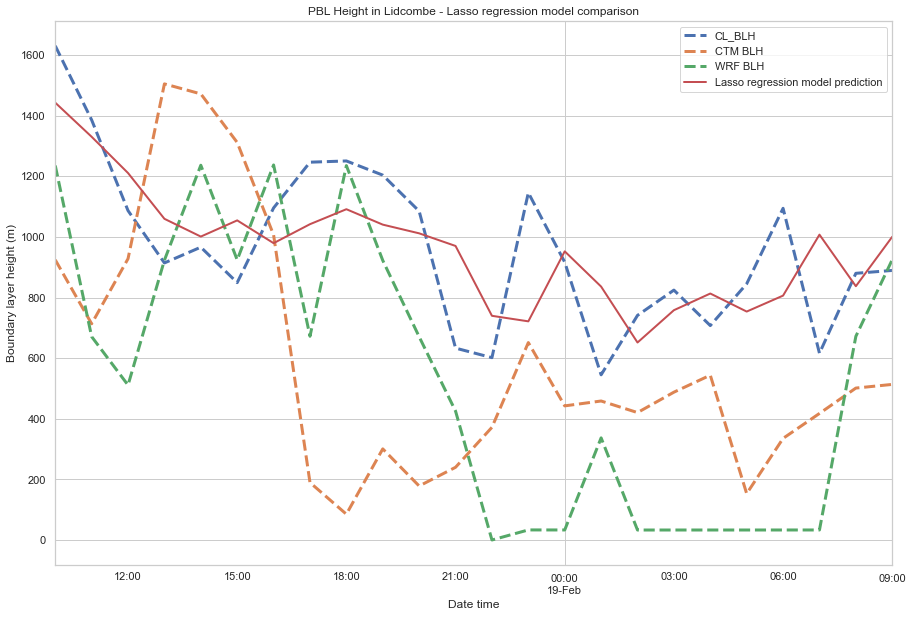

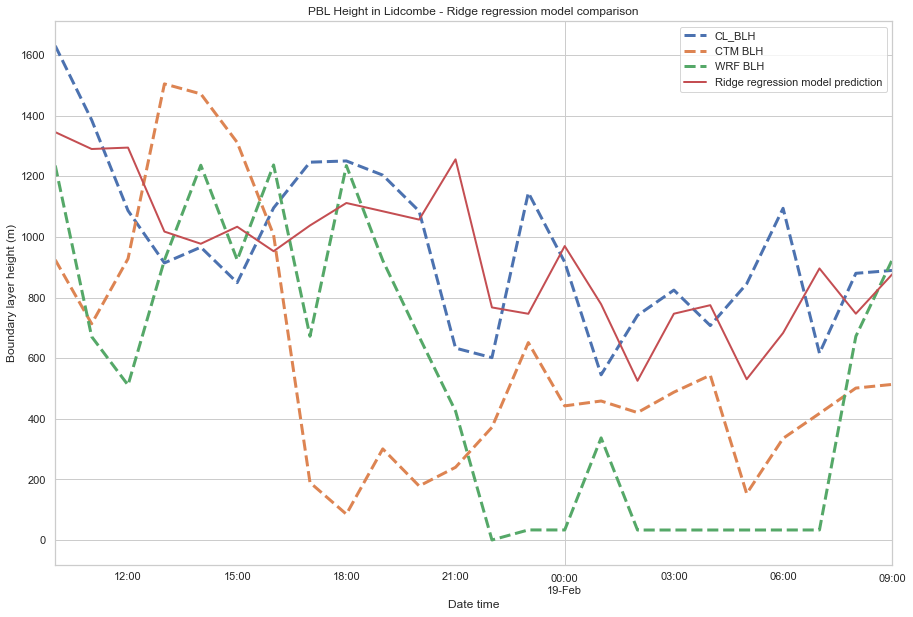

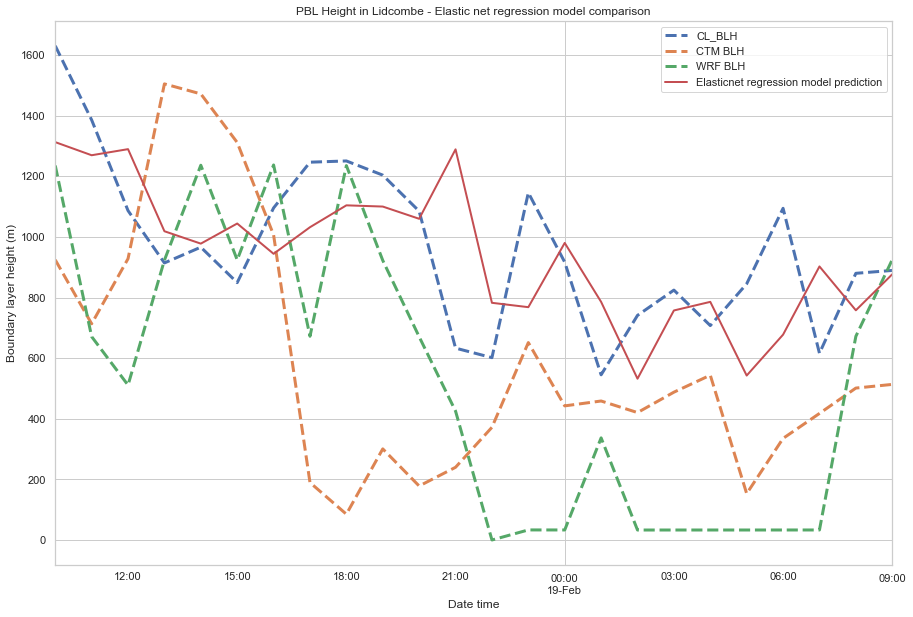

In [129]:
predicted_plots_combined(df_combined_predicted_lidcombe_rf_random,'PBL Height in Lidcombe - Random Forest model comparison')
predicted_plots_combined(df_combined_predicted_lidcombe_vreg_random,'PBL Height in Lidcombe - SVR model comparison')
predicted_plots_combined(df_combined_predicted_lidcombe_mulin,'PBL Height in Lidcombe - Multiple linear regression model comparison')
predicted_plots_combined(df_combined_predicted_lidcombe_dtree_random,'PBL Height in Lidcombe - Decision Tree model comparison')
predicted_plots_combined(df_combined_predicted_lidcombe_lasso_random,'PBL Height in Lidcombe - Lasso regression model comparison')
predicted_plots_combined(df_combined_predicted_lidcombe_ridge_random,'PBL Height in Lidcombe - Ridge regression model comparison')
predicted_plots_combined(df_combined_predicted_lidcombe_enet_random,'PBL Height in Lidcombe - Elastic net regression model comparison')

In [130]:
results_df_lidcombe_rf_grid = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
                                    df_rf_lidcombe_ld1['Predicted BLH']]

results_df_lidcombe_vreg_grid = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], 
                                    df_vreg_lidcombe_ld1['Predicted BLH']]

results_df_lidcombe_mulin = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], 
                                   df_mulin_lidcombe_ld['Predicted BLH']]

results_df_lidcombe_dtree_grid = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
                                    df_dtree_lidcombe_ld1['Predicted BLH']]

results_df_lidcombe_lasso_grid = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], 
                                    df_lasso_lidcombe_ld1['Predicted BLH']]

results_df_lidcombe_ridge_grid = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], 
                                   df_ridge_lidcombe_ld1['Predicted BLH']]

results_df_lidcombe_enet_grid = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
                                    df_enet_lidcombe_ld1['Predicted BLH']]



col_names_df_rf_grid = ['CTM BLH', 'WRF BLH', 'Random Forest(Grid) model prediction']
col_names_df_vreg_grid = ['CTM BLH', 'WRF BLH', 'SVR(Grid) model prediction']
col_names_df_mulin = ['CTM BLH', 'WRF BLH', 'Multiple linear regression(Grid) model prediction']
col_names_df_dtree_grid = ['CTM BLH', 'WRF BLH', 'Decision Tree(Grid) model prediction']
col_names_df_lasso_grid = ['CTM BLH', 'WRF BLH', 'Lasso regression(Grid) model prediction']
col_names_df_ridge_grid = ['CTM BLH', 'WRF BLH', 'Ridge regression(Grid) model prediction']
col_names_df_enet_grid = ['CTM BLH', 'WRF BLH', 'Elasticnet regression(Grid) model prediction']

df_combined_predicted_lidcombe_rf_grid = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_rf_grid, col_names_df_rf_grid)
df_combined_predicted_lidcombe_vreg_grid = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_vreg_grid, col_names_df_vreg_grid)
df_combined_predicted_lidcombe_mulin= combine_data_plots(df_lidcombe_filled, results_df_lidcombe_mulin, col_names_df_mulin)
df_combined_predicted_lidcombe_dtree_grid = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_dtree_grid, col_names_df_dtree_grid)
df_combined_predicted_lidcombe_lasso_grid = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_lasso_grid, col_names_df_lasso_grid)
df_combined_predicted_lidcombe_ridge_grid = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_ridge_grid, col_names_df_ridge_grid)
df_combined_predicted_lidcombe_enet_grid = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_enet_grid, col_names_df_enet_grid)

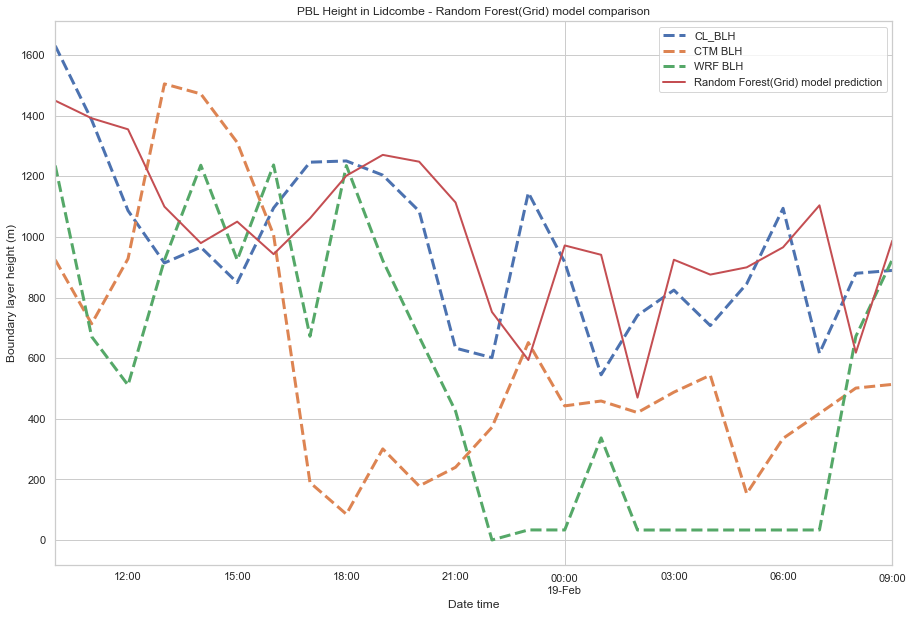

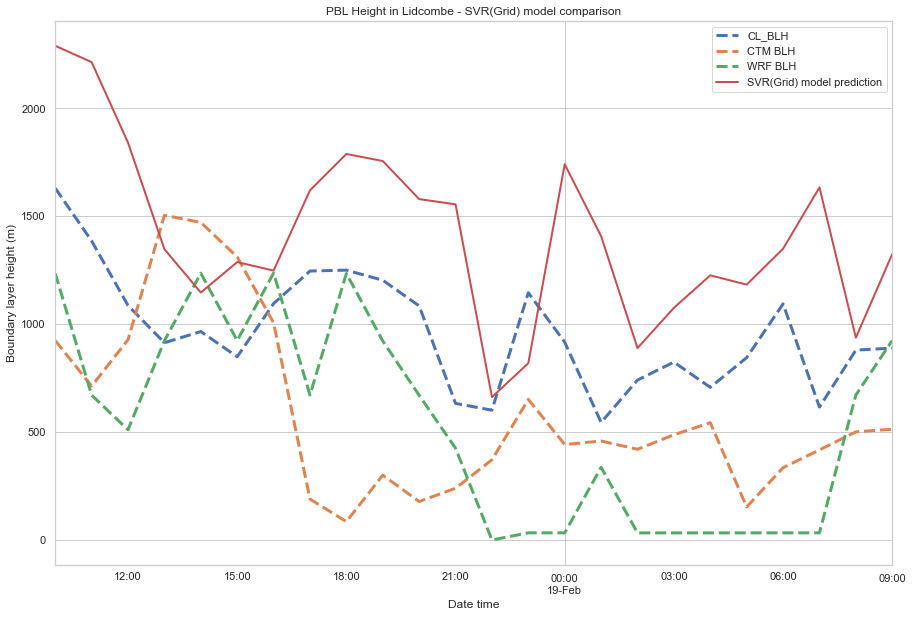

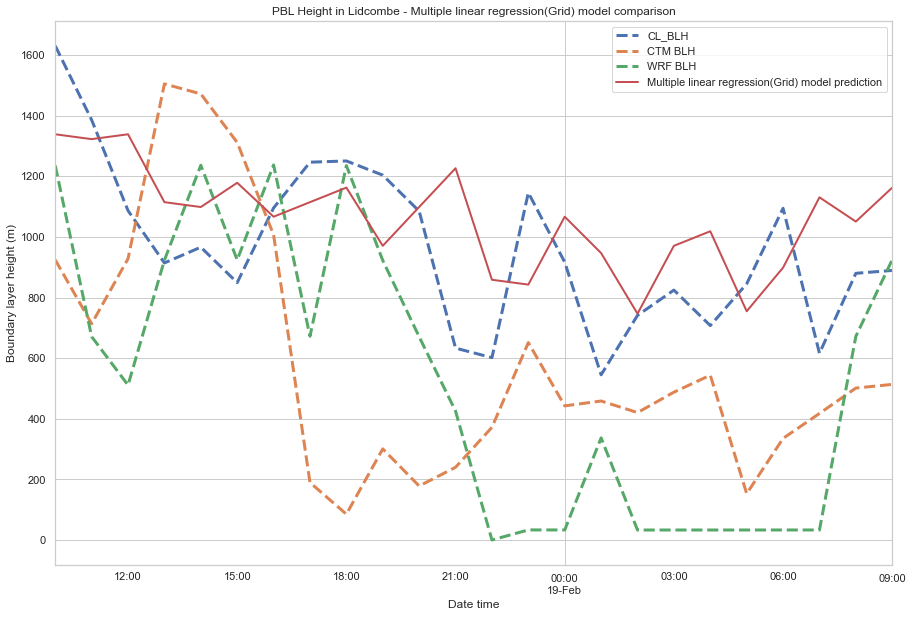

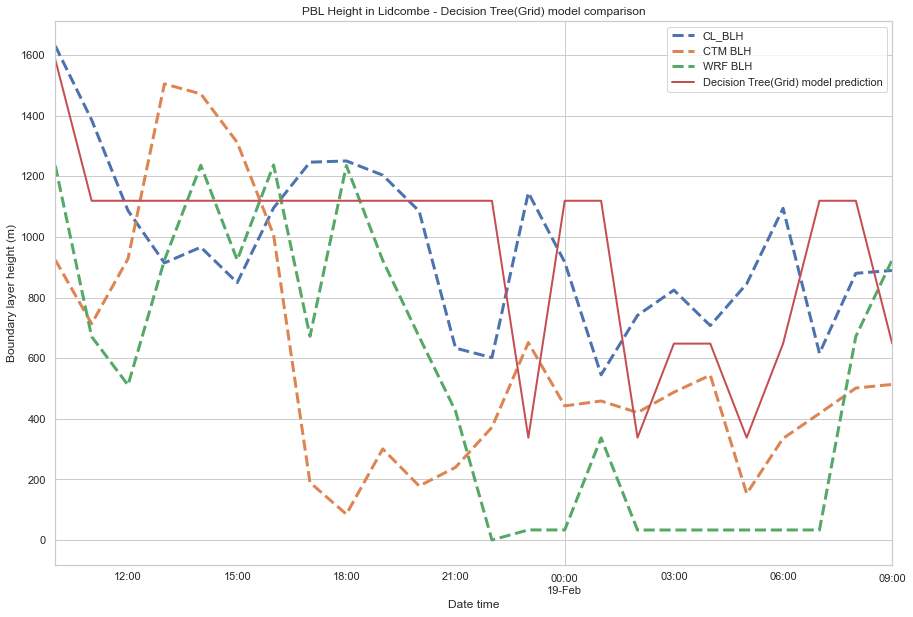

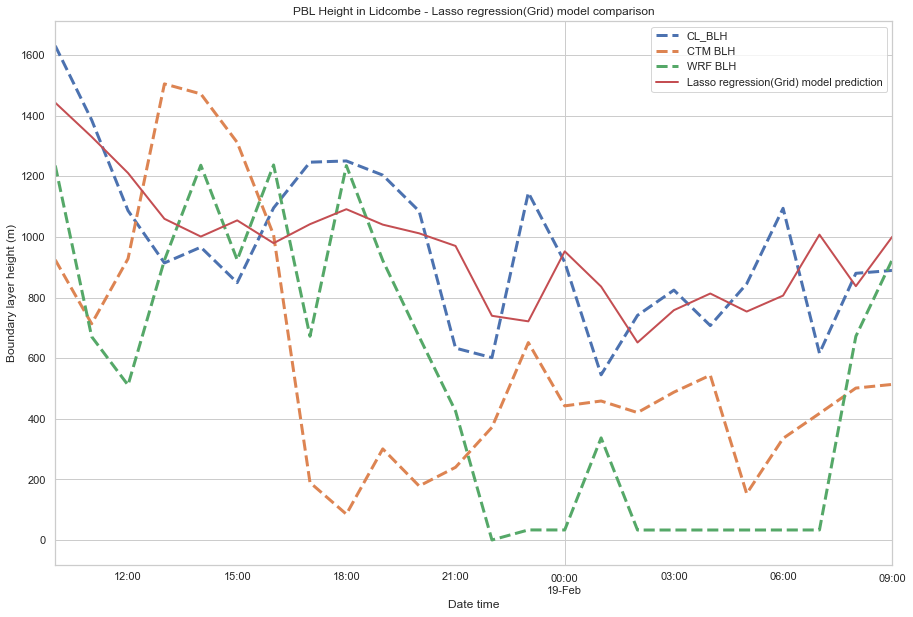

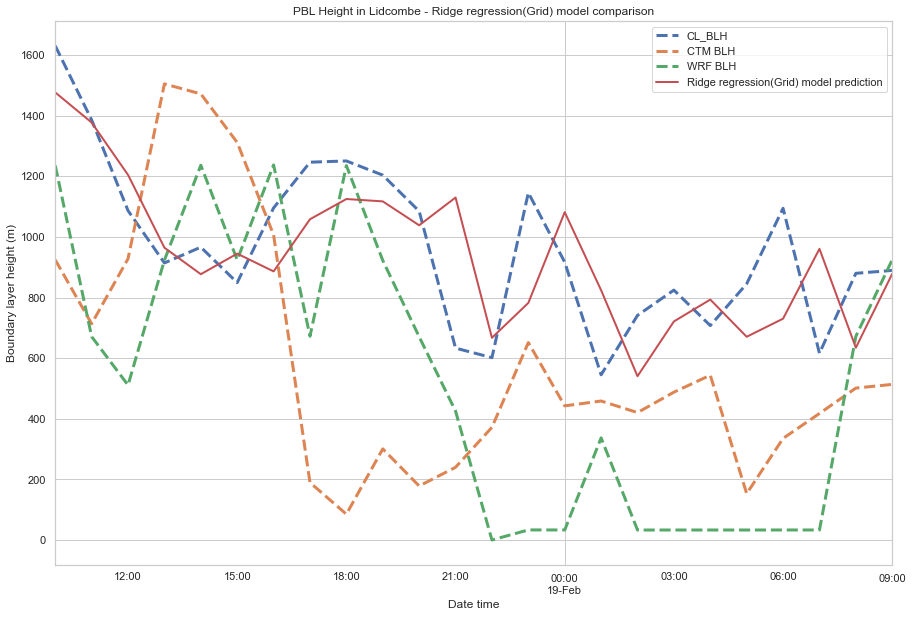

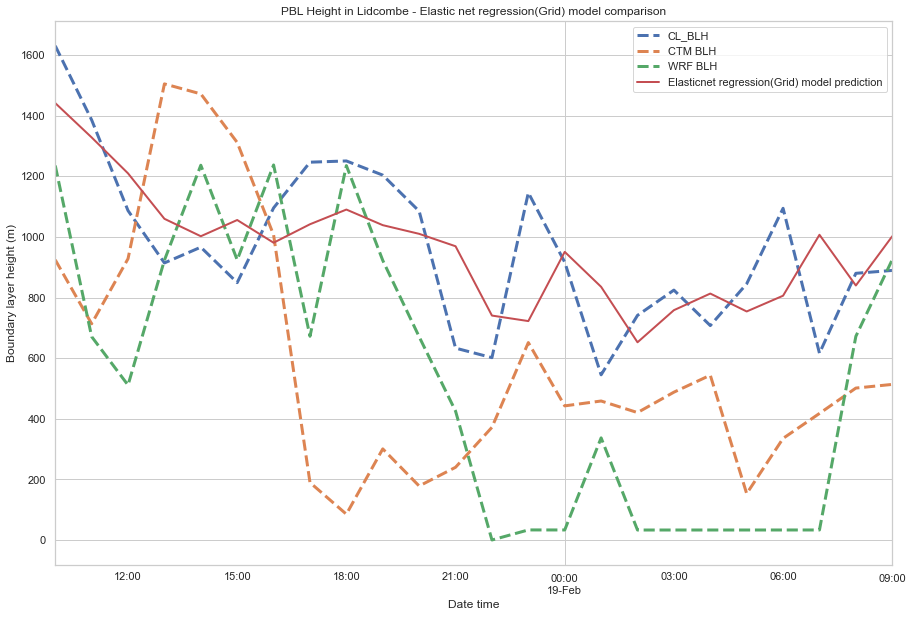

In [131]:
predicted_plots_combined(df_combined_predicted_lidcombe_rf_grid,'PBL Height in Lidcombe - Random Forest(Grid) model comparison')
predicted_plots_combined(df_combined_predicted_lidcombe_vreg_grid,'PBL Height in Lidcombe - SVR(Grid) model comparison')
predicted_plots_combined(df_combined_predicted_lidcombe_mulin,'PBL Height in Lidcombe - Multiple linear regression(Grid) model comparison')
predicted_plots_combined(df_combined_predicted_lidcombe_dtree_grid,'PBL Height in Lidcombe - Decision Tree(Grid) model comparison')
predicted_plots_combined(df_combined_predicted_lidcombe_lasso_grid,'PBL Height in Lidcombe - Lasso regression(Grid) model comparison')
predicted_plots_combined(df_combined_predicted_lidcombe_ridge_grid,'PBL Height in Lidcombe - Ridge regression(Grid) model comparison')
predicted_plots_combined(df_combined_predicted_lidcombe_enet_grid,'PBL Height in Lidcombe - Elastic net regression(Grid) model comparison')

### 4.2.3 Writing the results to CSV

In [132]:
results_df_merriwa_all = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
        df_rf_merriwa_ld['Predicted BLH'], df_vreg_merriwa_ld['Predicted BLH'],df_mulin_merriwa_ld['Predicted BLH'],                   
        df_dtree_merriwa_ld['Predicted BLH'], df_lasso_merriwa_ld['Predicted BLH'], df_ridge_merriwa_ld['Predicted BLH'],
        df_enet_merriwa_ld['Predicted BLH'], df_rf_merriwa_ld1['Predicted BLH'], df_vreg_merriwa_ld1['Predicted BLH'],                   
        df_dtree_merriwa_ld1['Predicted BLH'], df_lasso_merriwa_ld1['Predicted BLH'], df_ridge_merriwa_ld1['Predicted BLH'],
        df_enet_merriwa_ld1['Predicted BLH']]


results_df_lidcombe_all = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_rf_lidcombe_ld['Predicted BLH'], df_vreg_lidcombe_ld['Predicted BLH'],df_mulin_lidcombe_ld['Predicted BLH'],                   
        df_dtree_lidcombe_ld['Predicted BLH'], df_lasso_lidcombe_ld['Predicted BLH'], df_ridge_lidcombe_ld['Predicted BLH'],
        df_enet_lidcombe_ld['Predicted BLH'], df_rf_lidcombe_ld1['Predicted BLH'], df_vreg_lidcombe_ld1['Predicted BLH'],                   
        df_dtree_lidcombe_ld1['Predicted BLH'], df_lasso_lidcombe_ld1['Predicted BLH'], df_ridge_lidcombe_ld1['Predicted BLH'],
        df_enet_lidcombe_ld1['Predicted BLH']]


col_names_df_all = ['CTM BLH', 'WRF BLH', 
           'Random Forest ', 'SVR', 'Multiple Linear Regression',
            'Decision Tree', 'Lasso Regression', 'Ridge Regression',
            'Elasticnet Regression', 'Random Forest(Grid)', 'SVR(Grid)',
            'Decision Tree(Grid)', 'Lasso Regression(Grid)', 'Ridge Regression(Grid)',
            'Elasticnet Regression(Grid)']

In [133]:
#Write into DF
def statistical_metrics_on_df_to_df(y_true, y_pred, train_series):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    mase = MASE(train_series, y_pred, y_true)
    pears = pearson_corr(y_true, y_pred)
    
    df = pd.DataFrame([ioa, rmse, mae, mbe, dtw_dist, mase, pears])
    
    return df

In [134]:
#Function that writes out df for all results
def df_stat_results_combined(df_filled, results_df, train_series, col_names_df):
    index_dict = {0:'IOA', 1:'RMSE', 2:'MAE', 3:'MBE', 4:'DTW DIST', 5:'MASE', 6:'PEARSON'}
    
    y_true = df_filled.tail(24)['CL_BLH']
    
    #The first one is the CTM model
    y_pred = results_df[0]
    
    #Intialises the DF
    df_combined = statistical_metrics_on_df_to_df(y_true, y_pred, train_series)
    df_combined = df_combined.rename(columns = {0:'CTM model'})
    
    #Iterate
    for i in range(1, len(results_df)):
        y_pred_i = results_df[i]
        df_results_i = statistical_metrics_on_df_to_df(y_true, y_pred_i, train_series)        
        df_combined[col_names_df[i]] = df_results_i

    df_combined = df_combined.rename(index = index_dict)    
    
    return df_combined

In [135]:
df_stat_results_combined(df_merriwa_filled, results_df_merriwa_all,df_merriwa_filled.head(142)['CL_BLH'], col_names_df_all).to_csv('Merriwa_summary.csv')

In [136]:
df_stat_results_combined(df_lidcombe_filled, results_df_lidcombe_all,df_lidcombe_filled.head(142)['CL_BLH'], col_names_df_all).to_csv('Lidcombe_summary.csv')

In [137]:
df_rf_merriwa_ld.to_csv('RandomMerr1.csv', index = True)
df_rf_lidcombe_ld.to_csv('RandomLidc1.csv', index = True)

df_vreg_merriwa_ld.to_csv('SVRMerr1.csv', index = True)
df_vreg_lidcombe_ld.to_csv('SVRLidc1.csv', index = True)

df_mulin_merriwa_ld.to_csv('MulMerr1.csv', index = True)
df_mulin_lidcombe_ld.to_csv('MulLidc1.csv', index = True)

df_dtree_merriwa_ld.to_csv('DTMerr1.csv', index = True)
df_dtree_lidcombe_ld.to_csv('DTLidc1.csv', index = True)

df_lasso_merriwa_ld.to_csv('LassMerr1.csv', index = True)
df_lasso_lidcombe_ld.to_csv('LassLidc1.csv', index = True)

df_ridge_merriwa_ld.to_csv('RidMerr1.csv', index = True)
df_mulin_merriwa_ld.to_csv('RidLidc1.csv', index = True)

df_enet_merriwa_ld.to_csv('EnetMerr1.csv', index = True)
df_enet_lidcombe_ld.to_csv('EnetLidc1.csv', index = True)